
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase2<br>
    Soft Actor Critic<br>
<font color=696880 size=4>
    Ali Najar-Mohmmad Shafizade-Armin Khosravi




In this notebook, we are going to get familiar with SAC algorithm. Soft Actor Critic (SAC) is an off-policy algorithm that maximizes a combination of expected return **and** entropy. Higher entropy results in higher exploration, which is an important concept in Reinforcement Learning.

## 📦 Setup and Dependencies

Install PyBullet for Physics based environments.

In [3]:
!pip install -q pybullet Box2D
!nvidia-smi

Fri Sep  5 13:02:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Import necessary packages.

In [4]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import Normal

import warnings
warnings.filterwarnings('ignore')
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import pybullet_envs
np.bool8 = np.bool_
from tqdm.notebook import trange
from IPython.display import Video

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 📈 Utility codes

We will use this utility function to visualize the training progress.

In [5]:
def plot_learning_curve(x, filename, save_plot=True):
    avg_x = [np.mean(x[np.max([0, i - 100]):i]) for i in range(len(x))]
    plt.figure(dpi=200)
    plt.title('Learning Curve')
    plt.plot(range(len(x)), x, label='score', alpha=0.3)
    plt.plot(range(len(avg_x)), avg_x, label='average score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    if save_plot:
        plt.savefig(filename + '.png')
    plt.show()

This class implements a **Replay Buffer** to store and sample transitions of the form $(s_t, a_t, r_t, s_{t+1}, d_t)$ to break correlation in updates for stability in mini-batch stochastic gradient descent.


In [6]:
class ReplayBuffer:
    """
    A replay buffer for storing and sampling transitions.
    """
    def __init__(self, buffer_size, state_dims, action_dims):
        self.buffer_size = buffer_size
        self.ptr = 0
        self.is_full = False

        # Initialize buffer arrays to store states, next states, actions, rewards, and done flags
        self.states = np.zeros((self.buffer_size, *state_dims), dtype=np.float32)
        self.next_states = np.zeros((self.buffer_size, *state_dims), dtype=np.float32)
        self.actions = np.zeros((self.buffer_size, *action_dims), dtype=np.float32)
        self.rewards = np.zeros(self.buffer_size, dtype=np.float32)
        self.dones = np.zeros(self.buffer_size, dtype=np.bool_)

    def store_transition(self, state, action, reward, state_, done):
        """
        Stores a transition in the replay buffer.
        """
        self.states[self.ptr] = state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.next_states[self.ptr] = state_
        self.dones[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.buffer_size
        if self.ptr == 0 and not self.is_full:
            self.is_full = True

    def load_batch(self, batch_size):
        """
        Samples a random batch of transitions from the buffer.
        """
        max_mem = self.buffer_size if self.is_full else self.ptr
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.states[batch]
        actions = self.actions[batch]
        rewards = self.rewards[batch]
        states_ = self.next_states[batch]
        done = self.dones[batch]

        return states, actions, rewards, states_, done

## 🧱 Neural Networks

This cell defines three core neural networks used in SAC:

- **Critic Network:**
Estimates the **Q-value function** $ Q(s, a) $. Two critics are used to mitigate overestimation bias.

- **Value Network:**
Estimates the **state value function** $ V(s) $, used to train the actor and as a baseline.

- **Actor Network:**
Outputs the **mean** and **standard deviation** for a Gaussian policy
$
\pi(a|s) = \mathcal{N}(\mu(s), \sigma(s))
$.

In [7]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal
import os

class Critic(nn.Module):
    """
    Critic network that estimates the Q-value.
    """
    def __init__(self, beta, state_dims, action_dims, fc1_dims, fc2_dims, fc3_dims, name='Critic', ckpt_dir='tmp'):
        super(Critic, self).__init__()

        # Save input arguments as attributes
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.fc3_dims = fc3_dims
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(self.ckpt_dir, name)

        # Define the three fully connected layers
        self.fc1 = nn.Linear(self.state_dims[0] + self.action_dims[0], self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.fc3_dims)
        self.q = nn.Linear(self.fc3_dims, 1)

        # Define the optimizer and assign to the correct device
        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state, action):
        """
        Forward pass for the Critic network.
        """
        x = T.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        q = self.q(x)
        return q

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))

class Actor(nn.Module):
    """
    Actor network that produces the policy (action distribution).
    """
    def __init__(self, alpha, state_dims, action_dims, fc1_dims, fc2_dims, fc3_dims, max_action, reparam_noise,
                 name='Actor', ckpt_dir='tmp'):
        super(Actor, self).__init__()

        # Store initialization parameters
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.fc3_dims = fc3_dims
        self.max_action = max_action
        self.reparam_noise = reparam_noise
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(self.ckpt_dir, name)

        # Define three fully connected layers to transform input state
        self.fc1 = nn.Linear(*self.state_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.fc3_dims)

        # Output mean and standard deviation for the Gaussian policy
        self.mu = nn.Linear(self.fc3_dims, *self.action_dims)
        self.sigma = nn.Linear(self.fc3_dims, *self.action_dims)

        # Define optimizer and move model to the appropriate device
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        """
        Forward pass for the Actor network.
        """
        prob = self.fc1(state)
        prob = F.relu(prob)
        prob = self.fc2(prob)
        prob = F.relu(prob)
        prob = self.fc3(prob)
        prob = F.relu(prob)

        mu = self.mu(prob)
        sigma = self.sigma(prob)

        # Clamp sigma to ensure it's within a valid range
        sigma = T.clamp(sigma, min=self.reparam_noise, max=1)

        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        """
        Samples an action from the policy distribution.
        """
        # Use the actor to compute distribution parameters
        mu, sigma = self.forward(state)

        # Create a normal distribution and sample from it
        probabilities = Normal(mu, sigma)

        if reparameterize:
            actions = probabilities.rsample()  # Reparameterization trick
        else:
            actions = probabilities.sample()

        action = T.tanh(actions) * T.tensor(self.max_action).to(self.device)
        log_probs = probabilities.log_prob(actions)
        log_probs -= T.log(1-action.pow(2) + self.reparam_noise)
        log_probs = log_probs.sum(1, keepdim=True)

        return action, log_probs

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))

class Value(nn.Module):
    """
    Value network that estimates the state-value function.
    """
    def __init__(self, beta, state_dims, fc1_dims, fc2_dims, fc3_dims, name='Value', ckpt_dir='tmp'):
        super(Value, self).__init__()

        # Save arguments as instance variables
        self.state_dims = state_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.fc3_dims = fc3_dims
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(self.ckpt_dir, name)

        # Define the three fully connected layers for value approximation
        self.fc1 = nn.Linear(*self.state_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.fc3_dims)
        self.v = nn.Linear(self.fc3_dims, 1)

        # Set optimizer and device
        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        v = self.v(x)
        return v

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


## 🤖 Agent Implementation

This class encapsulates the full logic of the SAC agent. In general, the learning process uses entropy-regularized policy gradients $J_\pi = \mathbb{E}_{s_t \sim D, a_t \sim \pi} \left[ \alpha \log(\pi(a_t|s_t)) - Q(s_t, a_t) \right]$ with soft target updates $\theta_{\text{target}} \leftarrow \tau \theta + (1 - \tau)\theta_{\text{target}}$.

In [8]:
class Agent:
    """
    The SAC Agent.
    """
    def __init__(self, gamma, alpha, beta, state_dims, action_dims, max_action, fc1_dim, fc2_dim, fc3_dim,
                 memory_size, batch_size, tau, update_period, reward_scale, warmup, reparam_noise_lim,
                 name, ckpt_dir='tmp'):
        # Save all hyperparameters and paths
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.update_period = update_period
        self.reward_scale = reward_scale
        self.warmup = warmup
        self.time_steps = 0
        self.ckpt_dir = ckpt_dir

        model_name = f'{name}__' \
                     f'gamma_{gamma}__' \
                     f'alpha_{alpha}__' \
                     f'beta_{beta}__' \
                     f'fc1_{fc1_dim}__' \
                     f'fc2_{fc2_dim}__' \
                     f'fc3_{fc3_dim}__' \
                     f'bs_{batch_size}__' \
                     f'buffer_{memory_size}__' \
                     f'update_period_{update_period}__' \
                     f'tau_{tau}__'

        self.model_name = model_name
        self.learn_iter = 0
        self.full_path = os.path.join(self.ckpt_dir, self.model_name)
        os.makedirs(self.full_path, exist_ok=True)

        # Initialize the replay buffer
        self.memory = ReplayBuffer(memory_size, state_dims, action_dims)

        # Initialize Actor and Critic networks with 3 layers
        self.actor = Actor(alpha, state_dims, action_dims, fc1_dim, fc2_dim, fc3_dim, max_action,
                           reparam_noise_lim, name='actor', ckpt_dir=self.full_path)
        self.critic_1 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim, fc3_dim,
                               name='critic_1', ckpt_dir=self.full_path)
        self.critic_2 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim, fc3_dim,
                               name='critic_2', ckpt_dir=self.full_path)

        # Initialize Value and Target Value networks with 3 layers
        self.value = Value(beta, state_dims, fc1_dim, fc2_dim, fc3_dim, name='value', ckpt_dir=self.full_path)
        self.target_value = Value(beta, state_dims, fc1_dim, fc2_dim, fc3_dim, name='target_value', ckpt_dir=self.full_path)

        # Sync the parameters of value and target_value networks initially
        self.update_parameters(tau=1)

    def choose_action(self, state, deterministic=False, reparameterize=False):
        if self.time_steps < self.warmup:
            mu = T.tensor(np.random.normal(scale=0.1, size=self.actor.action_dims)).to(self.actor.device)
            return mu.cpu().detach().numpy()

        # Convert state to tensor, move to device, and add batch dimension
        state = T.tensor(state, dtype=T.float).unsqueeze(0).to(self.actor.device)

        # Choose action from actor
        if deterministic:
            mu, _ = self.actor.forward(state)
            action = T.tanh(mu) * T.tensor(self.actor.max_action).to(self.actor.device)
        else:
            action, _ = self.actor.sample_normal(state, reparameterize=reparameterize)

        return action.cpu().detach().numpy()[0]

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)
        self.time_steps += 1

    def load_batch(self):
        states, actions, rewards, states_, done = self.memory.load_batch(self.batch_size)

        states = T.tensor(states, dtype=T.float).to(self.actor.device)
        actions = T.tensor(actions, dtype=T.float).to(self.actor.device)
        rewards = T.tensor(rewards, dtype=T.float).to(self.actor.device)
        states_ = T.tensor(states_, dtype=T.float).to(self.actor.device)
        done = T.tensor(done).to(self.actor.device)

        return states, actions, rewards, states_, done

    def update_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        target_value_params = self.target_value.named_parameters()
        value_params = self.value.named_parameters()

        target_value_state_dict = dict(target_value_params)
        value_state_dict = dict(value_params)

        for name in value_state_dict:
            value_state_dict[name] = tau * value_state_dict[name].clone() + \
                                     (1 - tau) * target_value_state_dict[name].clone()

        self.target_value.load_state_dict(value_state_dict)

    def save_model(self):
        print('... saving checkpoint ...')
        self.actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        self.value.save_checkpoint()
        self.target_value.save_checkpoint()

    def load_model(self, gpu_to_cpu=False):
        print('... loading checkpoint ...')
        self.actor.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_1.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_2.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.target_value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)

    def learn(self):
        # Skip learning if buffer has insufficient samples
        if self.memory.ptr < self.batch_size:
            return

        # === VALUE LOSS ===
        # Load batch and sample action
        states, actions, rewards, states_, done = self.load_batch()

        # Estimate Q-values
        value = self.value(states).view(-1)

        # Sample new actions for value function calculation
        actions_new, log_probs = self.actor.sample_normal(states, reparameterize=False)
        log_probs = log_probs.view(-1)
        q1_new_policy = self.critic_1.forward(states, actions_new)
        q2_new_policy = self.critic_2.forward(states, actions_new)
        critic_value = T.min(q1_new_policy, q2_new_policy).view(-1)

        # Compute target value
        self.value.optimizer.zero_grad()
        value_target = critic_value - log_probs
        value_loss = 0.5 * F.mse_loss(value, value_target)
        value_loss.backward(retain_graph=True)
        self.value.optimizer.step()

        # === ACTOR LOSS ===
        # Re-sample actions (with reparameterization for gradients)
        actions_new, log_probs = self.actor.sample_normal(states, reparameterize=True)
        log_probs = log_probs.view(-1)
        q1_new_policy = self.critic_1.forward(states, actions_new)
        q2_new_policy = self.critic_2.forward(states, actions_new)
        critic_value = T.min(q1_new_policy, q2_new_policy).view(-1)

        # Compute actor loss
        actor_loss = log_probs - critic_value
        actor_loss = T.mean(actor_loss)
        self.actor.optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        self.actor.optimizer.step()

        # === CRITIC LOSS ===
        # Compute Q targets
        q_hat = self.reward_scale * rewards + self.gamma * self.target_value(states_).view(-1)
        q1_old_policy = self.critic_1.forward(states, actions).view(-1)
        q2_old_policy = self.critic_2.forward(states, actions).view(-1)

        # Compute MSE loss for both critics
        self.critic_1.optimizer.zero_grad()
        self.critic_2.optimizer.zero_grad()
        critic_1_loss = 0.5 * F.mse_loss(q1_old_policy, q_hat)
        critic_2_loss = 0.5 * F.mse_loss(q2_old_policy, q_hat)

        critic_loss = critic_1_loss + critic_2_loss
        critic_loss.backward()
        self.critic_1.optimizer.step()
        self.critic_2.optimizer.step()

        # === TARGET NETWORK UPDATE ===
        self.learn_iter += 1
        if self.learn_iter % self.update_period == 0:
            self.update_parameters()


## ⚙️ Training Configuration

Set up your training parameters. `HalfCheetahBulletEnv-v0` is a continuous control task where the agent must learn to run using articulated legs.


In [13]:
# --- Configuration parameters ---
env_name = 'HalfCheetah-v4'
dir = 'tmp'
n_games = 600

# Hyperparameters
gamma = 0.99
alpha = 6e-4  # Actor learning rate
beta = 6e-4   # Critic and Value learning rate
fc1_dim = 400
fc2_dim = 300
fc3_dim = 64
memory_size = 1_000_000
batch_size = 256
tau = 0.005 # Soft update parameter
update_period = 1
reward_scale = 5.0
warmup = 1000
reparam_noise_lim = 1e-6
record_video = True

## 🚀 Training Loop

For each episode, interact with the environment to collect transitions, then update the SAC networks and save the best model.

After training, a learning curve is plotted to visualize convergence and performance stability.

/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(
  0%|          | 1/600 [00:11<1:56:48, 11.70s/it]

| Game:      0 | Score:      -9.34 | Best score:   -1000.00 | Avg score      -9.34 | Learning iter:        745 |


  0%|          | 2/600 [00:27<2:21:32, 14.20s/it]

... saving checkpoint ...
| Game:      1 | Score:    -211.11 | Best score:    -110.23 | Avg score    -110.23 | Learning iter:       1745 |


  0%|          | 3/600 [00:44<2:31:59, 15.28s/it]

| Game:      2 | Score:    -159.80 | Best score:    -110.23 | Avg score    -126.75 | Learning iter:       2745 |


  1%|          | 4/600 [01:01<2:39:45, 16.08s/it]

| Game:      3 | Score:     -94.32 | Best score:    -110.23 | Avg score    -118.64 | Learning iter:       3745 |


  1%|          | 5/600 [01:17<2:40:36, 16.20s/it]

| Game:      4 | Score:    -176.17 | Best score:    -110.23 | Avg score    -130.15 | Learning iter:       4745 |


  1%|          | 6/600 [01:34<2:40:07, 16.17s/it]

| Game:      5 | Score:    -190.46 | Best score:    -110.23 | Avg score    -140.20 | Learning iter:       5745 |


  1%|          | 7/600 [01:50<2:39:34, 16.15s/it]

| Game:      6 | Score:    -160.24 | Best score:    -110.23 | Avg score    -143.06 | Learning iter:       6745 |


  1%|▏         | 8/600 [02:06<2:40:18, 16.25s/it]

| Game:      7 | Score:    -154.95 | Best score:    -110.23 | Avg score    -144.55 | Learning iter:       7745 |


  2%|▏         | 9/600 [02:22<2:39:43, 16.22s/it]

| Game:      8 | Score:    -196.62 | Best score:    -110.23 | Avg score    -150.33 | Learning iter:       8745 |


  2%|▏         | 10/600 [02:38<2:39:09, 16.19s/it]

| Game:      9 | Score:    -233.88 | Best score:    -110.23 | Avg score    -158.69 | Learning iter:       9745 |


  2%|▏         | 11/600 [02:55<2:40:05, 16.31s/it]

| Game:     10 | Score:    -161.81 | Best score:    -110.23 | Avg score    -158.97 | Learning iter:      10745 |


  2%|▏         | 12/600 [03:11<2:39:28, 16.27s/it]

| Game:     11 | Score:    -111.52 | Best score:    -110.23 | Avg score    -155.02 | Learning iter:      11745 |


  2%|▏         | 13/600 [03:27<2:38:53, 16.24s/it]

| Game:     12 | Score:     -86.26 | Best score:    -110.23 | Avg score    -149.73 | Learning iter:      12745 |


  2%|▏         | 14/600 [03:44<2:40:07, 16.40s/it]

| Game:     13 | Score:     -96.83 | Best score:    -110.23 | Avg score    -145.95 | Learning iter:      13745 |


  2%|▎         | 15/600 [04:00<2:39:13, 16.33s/it]

| Game:     14 | Score:     -88.03 | Best score:    -110.23 | Avg score    -142.09 | Learning iter:      14745 |


  3%|▎         | 16/600 [04:16<2:38:27, 16.28s/it]

| Game:     15 | Score:     -52.17 | Best score:    -110.23 | Avg score    -136.47 | Learning iter:      15745 |


  3%|▎         | 17/600 [04:33<2:39:45, 16.44s/it]

| Game:     16 | Score:     -39.39 | Best score:    -110.23 | Avg score    -130.76 | Learning iter:      16745 |


  3%|▎         | 18/600 [04:50<2:39:35, 16.45s/it]

| Game:     17 | Score:     -77.19 | Best score:    -110.23 | Avg score    -127.78 | Learning iter:      17745 |


  3%|▎         | 19/600 [05:06<2:38:39, 16.39s/it]

| Game:     18 | Score:      25.94 | Best score:    -110.23 | Avg score    -119.69 | Learning iter:      18745 |


  3%|▎         | 20/600 [05:23<2:39:27, 16.50s/it]

| Game:     19 | Score:     -30.95 | Best score:    -110.23 | Avg score    -115.26 | Learning iter:      19745 |


  4%|▎         | 21/600 [05:39<2:38:37, 16.44s/it]

... saving checkpoint ...
| Game:     20 | Score:      63.41 | Best score:    -106.75 | Avg score    -106.75 | Learning iter:      20745 |


  4%|▎         | 22/600 [05:56<2:38:36, 16.46s/it]

... saving checkpoint ...
| Game:     21 | Score:      -5.45 | Best score:    -102.14 | Avg score    -102.14 | Learning iter:      21745 |


  4%|▍         | 23/600 [06:12<2:38:54, 16.52s/it]

... saving checkpoint ...
| Game:     22 | Score:      52.84 | Best score:     -95.40 | Avg score     -95.40 | Learning iter:      22745 |


  4%|▍         | 24/600 [06:29<2:38:10, 16.48s/it]

... saving checkpoint ...
| Game:     23 | Score:      47.73 | Best score:     -89.44 | Avg score     -89.44 | Learning iter:      23745 |


  4%|▍         | 25/600 [06:45<2:38:31, 16.54s/it]

... saving checkpoint ...
| Game:     24 | Score:      66.57 | Best score:     -83.20 | Avg score     -83.20 | Learning iter:      24745 |


  4%|▍         | 26/600 [07:01<2:37:25, 16.45s/it]

... saving checkpoint ...
| Game:     25 | Score:      99.84 | Best score:     -76.16 | Avg score     -76.16 | Learning iter:      25745 |


  4%|▍         | 27/600 [07:18<2:36:50, 16.42s/it]

... saving checkpoint ...
| Game:     26 | Score:     166.27 | Best score:     -67.18 | Avg score     -67.18 | Learning iter:      26745 |


  5%|▍         | 28/600 [07:35<2:37:39, 16.54s/it]

... saving checkpoint ...
| Game:     27 | Score:     100.75 | Best score:     -61.18 | Avg score     -61.18 | Learning iter:      27745 |


  5%|▍         | 29/600 [07:51<2:36:50, 16.48s/it]

... saving checkpoint ...
| Game:     28 | Score:     190.69 | Best score:     -52.50 | Avg score     -52.50 | Learning iter:      28745 |


  5%|▌         | 30/600 [08:07<2:36:03, 16.43s/it]

... saving checkpoint ...
| Game:     29 | Score:     217.33 | Best score:     -43.50 | Avg score     -43.50 | Learning iter:      29745 |


  5%|▌         | 31/600 [08:24<2:37:06, 16.57s/it]

... saving checkpoint ...
| Game:     30 | Score:     207.31 | Best score:     -35.41 | Avg score     -35.41 | Learning iter:      30745 |


  5%|▌         | 32/600 [08:41<2:36:21, 16.52s/it]

... saving checkpoint ...
| Game:     31 | Score:     260.91 | Best score:     -26.15 | Avg score     -26.15 | Learning iter:      31745 |


  6%|▌         | 33/600 [08:57<2:36:11, 16.53s/it]

... saving checkpoint ...
| Game:     32 | Score:     333.26 | Best score:     -15.26 | Avg score     -15.26 | Learning iter:      32745 |


  6%|▌         | 34/600 [09:14<2:36:33, 16.60s/it]

... saving checkpoint ...
| Game:     33 | Score:     378.59 | Best score:      -3.68 | Avg score      -3.68 | Learning iter:      33745 |


  6%|▌         | 35/600 [09:30<2:35:33, 16.52s/it]

... saving checkpoint ...
| Game:     34 | Score:     345.03 | Best score:       6.28 | Avg score       6.28 | Learning iter:      34745 |


  6%|▌         | 36/600 [09:47<2:37:03, 16.71s/it]

... saving checkpoint ...
| Game:     35 | Score:     490.89 | Best score:      19.75 | Avg score      19.75 | Learning iter:      35745 |


  6%|▌         | 37/600 [10:04<2:36:18, 16.66s/it]

... saving checkpoint ...
| Game:     36 | Score:     451.74 | Best score:      31.42 | Avg score      31.42 | Learning iter:      36745 |


  6%|▋         | 38/600 [10:21<2:35:47, 16.63s/it]

... saving checkpoint ...
| Game:     37 | Score:     466.74 | Best score:      42.88 | Avg score      42.88 | Learning iter:      37745 |


  6%|▋         | 39/600 [10:38<2:36:40, 16.76s/it]

... saving checkpoint ...
| Game:     38 | Score:     455.57 | Best score:      53.46 | Avg score      53.46 | Learning iter:      38745 |


  7%|▋         | 40/600 [10:54<2:36:12, 16.74s/it]

... saving checkpoint ...
| Game:     39 | Score:     472.20 | Best score:      63.93 | Avg score      63.93 | Learning iter:      39745 |


  7%|▋         | 41/600 [11:11<2:36:21, 16.78s/it]

... saving checkpoint ...
| Game:     40 | Score:     533.37 | Best score:      75.38 | Avg score      75.38 | Learning iter:      40745 |


  7%|▋         | 42/600 [11:28<2:36:51, 16.87s/it]

... saving checkpoint ...
| Game:     41 | Score:     556.10 | Best score:      86.82 | Avg score      86.82 | Learning iter:      41745 |


  7%|▋         | 43/600 [11:45<2:36:02, 16.81s/it]

... saving checkpoint ...
| Game:     42 | Score:     452.20 | Best score:      95.32 | Avg score      95.32 | Learning iter:      42745 |


  7%|▋         | 44/600 [12:02<2:36:47, 16.92s/it]

... saving checkpoint ...
| Game:     43 | Score:     574.65 | Best score:     106.21 | Avg score     106.21 | Learning iter:      43745 |


  8%|▊         | 45/600 [12:19<2:35:47, 16.84s/it]

... saving checkpoint ...
| Game:     44 | Score:     509.32 | Best score:     115.17 | Avg score     115.17 | Learning iter:      44745 |


  8%|▊         | 46/600 [12:36<2:35:36, 16.85s/it]

... saving checkpoint ...
| Game:     45 | Score:     573.85 | Best score:     125.14 | Avg score     125.14 | Learning iter:      45745 |


  8%|▊         | 47/600 [12:53<2:35:41, 16.89s/it]

... saving checkpoint ...
| Game:     46 | Score:     505.24 | Best score:     133.23 | Avg score     133.23 | Learning iter:      46745 |


  8%|▊         | 48/600 [13:09<2:34:46, 16.82s/it]

... saving checkpoint ...
| Game:     47 | Score:     577.09 | Best score:     142.48 | Avg score     142.48 | Learning iter:      47745 |


  8%|▊         | 49/600 [13:26<2:35:28, 16.93s/it]

... saving checkpoint ...
| Game:     48 | Score:     534.63 | Best score:     150.48 | Avg score     150.48 | Learning iter:      48745 |


  8%|▊         | 50/600 [13:43<2:34:23, 16.84s/it]

... saving checkpoint ...
| Game:     49 | Score:     646.87 | Best score:     160.41 | Avg score     160.41 | Learning iter:      49745 |


  8%|▊         | 51/600 [14:00<2:33:50, 16.81s/it]

... saving checkpoint ...
| Game:     50 | Score:     590.47 | Best score:     168.84 | Avg score     168.84 | Learning iter:      50745 |


  9%|▊         | 52/600 [14:17<2:34:25, 16.91s/it]

... saving checkpoint ...
| Game:     51 | Score:     601.11 | Best score:     177.15 | Avg score     177.15 | Learning iter:      51745 |


  9%|▉         | 53/600 [14:34<2:33:31, 16.84s/it]

... saving checkpoint ...
| Game:     52 | Score:     677.60 | Best score:     186.60 | Avg score     186.60 | Learning iter:      52745 |


  9%|▉         | 54/600 [14:51<2:34:27, 16.97s/it]

... saving checkpoint ...
| Game:     53 | Score:     730.70 | Best score:     196.67 | Avg score     196.67 | Learning iter:      53745 |


  9%|▉         | 55/600 [15:07<2:33:05, 16.85s/it]

... saving checkpoint ...
| Game:     54 | Score:     649.15 | Best score:     204.90 | Avg score     204.90 | Learning iter:      54745 |


  9%|▉         | 56/600 [15:24<2:32:25, 16.81s/it]

... saving checkpoint ...
| Game:     55 | Score:     702.96 | Best score:     213.79 | Avg score     213.79 | Learning iter:      55745 |


 10%|▉         | 57/600 [15:41<2:33:12, 16.93s/it]

... saving checkpoint ...
| Game:     56 | Score:     647.37 | Best score:     221.40 | Avg score     221.40 | Learning iter:      56745 |


 10%|▉         | 58/600 [15:58<2:32:08, 16.84s/it]

... saving checkpoint ...
| Game:     57 | Score:     672.02 | Best score:     229.17 | Avg score     229.17 | Learning iter:      57745 |


 10%|▉         | 59/600 [16:15<2:32:50, 16.95s/it]

... saving checkpoint ...
| Game:     58 | Score:     734.24 | Best score:     237.73 | Avg score     237.73 | Learning iter:      58745 |


 10%|█         | 60/600 [16:32<2:32:14, 16.92s/it]

... saving checkpoint ...
| Game:     59 | Score:     739.33 | Best score:     246.09 | Avg score     246.09 | Learning iter:      59745 |


 10%|█         | 61/600 [16:49<2:31:50, 16.90s/it]

... saving checkpoint ...
| Game:     60 | Score:     644.77 | Best score:     252.63 | Avg score     252.63 | Learning iter:      60745 |


 10%|█         | 62/600 [17:06<2:32:52, 17.05s/it]

... saving checkpoint ...
| Game:     61 | Score:     670.80 | Best score:     259.37 | Avg score     259.37 | Learning iter:      61745 |


 10%|█         | 63/600 [17:23<2:31:55, 16.97s/it]

... saving checkpoint ...
| Game:     62 | Score:     736.14 | Best score:     266.94 | Avg score     266.94 | Learning iter:      62745 |


 11%|█         | 64/600 [17:40<2:32:25, 17.06s/it]

... saving checkpoint ...
| Game:     63 | Score:     667.98 | Best score:     273.20 | Avg score     273.20 | Learning iter:      63745 |


 11%|█         | 65/600 [17:57<2:31:27, 16.99s/it]

... saving checkpoint ...
| Game:     64 | Score:     723.85 | Best score:     280.14 | Avg score     280.14 | Learning iter:      64745 |


 11%|█         | 66/600 [18:14<2:30:26, 16.90s/it]

... saving checkpoint ...
| Game:     65 | Score:     800.16 | Best score:     288.02 | Avg score     288.02 | Learning iter:      65745 |


 11%|█         | 67/600 [18:31<2:31:39, 17.07s/it]

... saving checkpoint ...
| Game:     66 | Score:     783.70 | Best score:     295.41 | Avg score     295.41 | Learning iter:      66745 |


 11%|█▏        | 68/600 [18:48<2:30:46, 17.01s/it]

... saving checkpoint ...
| Game:     67 | Score:     782.40 | Best score:     302.58 | Avg score     302.58 | Learning iter:      67745 |


 12%|█▏        | 69/600 [19:06<2:31:33, 17.12s/it]

... saving checkpoint ...
| Game:     68 | Score:     812.85 | Best score:     309.97 | Avg score     309.97 | Learning iter:      68745 |


 12%|█▏        | 70/600 [19:22<2:30:34, 17.05s/it]

... saving checkpoint ...
| Game:     69 | Score:     747.39 | Best score:     316.22 | Avg score     316.22 | Learning iter:      69745 |


 12%|█▏        | 71/600 [19:39<2:29:55, 17.01s/it]

... saving checkpoint ...
| Game:     70 | Score:     826.66 | Best score:     323.41 | Avg score     323.41 | Learning iter:      70745 |


 12%|█▏        | 72/600 [19:57<2:30:35, 17.11s/it]

... saving checkpoint ...
| Game:     71 | Score:     790.04 | Best score:     329.89 | Avg score     329.89 | Learning iter:      71745 |


 12%|█▏        | 73/600 [20:14<2:29:33, 17.03s/it]

... saving checkpoint ...
| Game:     72 | Score:     713.17 | Best score:     335.14 | Avg score     335.14 | Learning iter:      72745 |


 12%|█▏        | 74/600 [20:31<2:30:35, 17.18s/it]

... saving checkpoint ...
| Game:     73 | Score:     829.91 | Best score:     341.83 | Avg score     341.83 | Learning iter:      73745 |


 12%|█▎        | 75/600 [20:48<2:29:35, 17.10s/it]

... saving checkpoint ...
| Game:     74 | Score:     739.19 | Best score:     347.13 | Avg score     347.13 | Learning iter:      74745 |


 13%|█▎        | 76/600 [21:05<2:29:34, 17.13s/it]

... saving checkpoint ...
| Game:     75 | Score:     880.53 | Best score:     354.14 | Avg score     354.14 | Learning iter:      75745 |


 13%|█▎        | 77/600 [21:23<2:29:51, 17.19s/it]

... saving checkpoint ...
| Game:     76 | Score:     859.71 | Best score:     360.71 | Avg score     360.71 | Learning iter:      76745 |


 13%|█▎        | 78/600 [21:40<2:29:12, 17.15s/it]

... saving checkpoint ...
| Game:     77 | Score:     855.62 | Best score:     367.05 | Avg score     367.05 | Learning iter:      77745 |


 13%|█▎        | 79/600 [21:57<2:30:06, 17.29s/it]

... saving checkpoint ...
| Game:     78 | Score:     844.97 | Best score:     373.10 | Avg score     373.10 | Learning iter:      78745 |


 13%|█▎        | 80/600 [22:14<2:29:03, 17.20s/it]

... saving checkpoint ...
| Game:     79 | Score:     808.55 | Best score:     378.55 | Avg score     378.55 | Learning iter:      79745 |


 14%|█▎        | 81/600 [22:32<2:30:09, 17.36s/it]

... saving checkpoint ...
| Game:     80 | Score:     841.83 | Best score:     384.27 | Avg score     384.27 | Learning iter:      80745 |


 14%|█▎        | 82/600 [22:49<2:28:54, 17.25s/it]

... saving checkpoint ...
| Game:     81 | Score:     878.62 | Best score:     390.30 | Avg score     390.30 | Learning iter:      81745 |


 14%|█▍        | 83/600 [23:06<2:28:50, 17.27s/it]

... saving checkpoint ...
| Game:     82 | Score:     779.25 | Best score:     394.98 | Avg score     394.98 | Learning iter:      82745 |


 14%|█▍        | 84/600 [23:24<2:28:58, 17.32s/it]

... saving checkpoint ...
| Game:     83 | Score:    1002.07 | Best score:     402.21 | Avg score     402.21 | Learning iter:      83745 |


 14%|█▍        | 85/600 [23:41<2:27:56, 17.24s/it]

... saving checkpoint ...
| Game:     84 | Score:     926.14 | Best score:     408.37 | Avg score     408.37 | Learning iter:      84745 |


 14%|█▍        | 86/600 [23:58<2:28:52, 17.38s/it]

... saving checkpoint ...
| Game:     85 | Score:     908.31 | Best score:     414.19 | Avg score     414.19 | Learning iter:      85745 |


 14%|█▍        | 87/600 [24:16<2:27:51, 17.29s/it]

... saving checkpoint ...
| Game:     86 | Score:     871.36 | Best score:     419.44 | Avg score     419.44 | Learning iter:      86745 |


 15%|█▍        | 88/600 [24:33<2:28:43, 17.43s/it]

... saving checkpoint ...
| Game:     87 | Score:     954.73 | Best score:     425.52 | Avg score     425.52 | Learning iter:      87745 |


 15%|█▍        | 89/600 [24:50<2:27:30, 17.32s/it]

... saving checkpoint ...
| Game:     88 | Score:     959.21 | Best score:     431.52 | Avg score     431.52 | Learning iter:      88745 |


 15%|█▌        | 90/600 [25:08<2:28:01, 17.41s/it]

... saving checkpoint ...
| Game:     89 | Score:     959.48 | Best score:     437.39 | Avg score     437.39 | Learning iter:      89745 |


 15%|█▌        | 91/600 [25:25<2:27:35, 17.40s/it]

... saving checkpoint ...
| Game:     90 | Score:     961.34 | Best score:     443.14 | Avg score     443.14 | Learning iter:      90745 |


 15%|█▌        | 92/600 [25:43<2:26:48, 17.34s/it]

... saving checkpoint ...
| Game:     91 | Score:     877.76 | Best score:     447.87 | Avg score     447.87 | Learning iter:      91745 |


 16%|█▌        | 93/600 [26:00<2:27:47, 17.49s/it]

... saving checkpoint ...
| Game:     92 | Score:     961.99 | Best score:     453.40 | Avg score     453.40 | Learning iter:      92745 |


 16%|█▌        | 94/600 [26:18<2:26:59, 17.43s/it]

... saving checkpoint ...
| Game:     93 | Score:     978.23 | Best score:     458.98 | Avg score     458.98 | Learning iter:      93745 |


 16%|█▌        | 95/600 [26:36<2:27:58, 17.58s/it]

... saving checkpoint ...
| Game:     94 | Score:     964.74 | Best score:     464.30 | Avg score     464.30 | Learning iter:      94745 |


 16%|█▌        | 96/600 [26:53<2:27:26, 17.55s/it]

... saving checkpoint ...
| Game:     95 | Score:     949.70 | Best score:     469.36 | Avg score     469.36 | Learning iter:      95745 |


 16%|█▌        | 97/600 [27:11<2:28:00, 17.65s/it]

... saving checkpoint ...
| Game:     96 | Score:    1024.25 | Best score:     475.08 | Avg score     475.08 | Learning iter:      96745 |


 16%|█▋        | 98/600 [27:28<2:26:57, 17.57s/it]

... saving checkpoint ...
| Game:     97 | Score:    1024.50 | Best score:     480.69 | Avg score     480.69 | Learning iter:      97745 |


 16%|█▋        | 99/600 [27:46<2:27:41, 17.69s/it]

... saving checkpoint ...
| Game:     98 | Score:     940.98 | Best score:     485.34 | Avg score     485.34 | Learning iter:      98745 |


 17%|█▋        | 100/600 [28:04<2:26:37, 17.59s/it]

... saving checkpoint ...
| Game:     99 | Score:    1002.96 | Best score:     490.51 | Avg score     490.51 | Learning iter:      99745 |


 17%|█▋        | 101/600 [28:21<2:26:35, 17.63s/it]

... saving checkpoint ...
| Game:    100 | Score:    1060.59 | Best score:     501.21 | Avg score     501.21 | Learning iter:     100745 |


 17%|█▋        | 102/600 [28:39<2:26:34, 17.66s/it]

... saving checkpoint ...
| Game:    101 | Score:    1006.62 | Best score:     513.39 | Avg score     513.39 | Learning iter:     101745 |


 17%|█▋        | 103/600 [28:57<2:26:08, 17.64s/it]

... saving checkpoint ...
| Game:    102 | Score:    1016.39 | Best score:     525.15 | Avg score     525.15 | Learning iter:     102745 |


 17%|█▋        | 104/600 [29:15<2:26:56, 17.78s/it]

... saving checkpoint ...
| Game:    103 | Score:    1000.89 | Best score:     536.10 | Avg score     536.10 | Learning iter:     103745 |


 18%|█▊        | 105/600 [29:32<2:25:47, 17.67s/it]

... saving checkpoint ...
| Game:    104 | Score:    1063.05 | Best score:     548.50 | Avg score     548.50 | Learning iter:     104745 |


 18%|█▊        | 106/600 [29:50<2:26:23, 17.78s/it]

... saving checkpoint ...
| Game:    105 | Score:     992.50 | Best score:     560.33 | Avg score     560.33 | Learning iter:     105745 |


 18%|█▊        | 107/600 [30:08<2:25:19, 17.69s/it]

... saving checkpoint ...
| Game:    106 | Score:    1035.89 | Best score:     572.29 | Avg score     572.29 | Learning iter:     106745 |


 18%|█▊        | 108/600 [30:26<2:25:48, 17.78s/it]

... saving checkpoint ...
| Game:    107 | Score:    1091.61 | Best score:     584.75 | Avg score     584.75 | Learning iter:     107745 |


 18%|█▊        | 109/600 [30:43<2:24:50, 17.70s/it]

... saving checkpoint ...
| Game:    108 | Score:    1131.68 | Best score:     598.03 | Avg score     598.03 | Learning iter:     108745 |


 18%|█▊        | 110/600 [31:01<2:25:20, 17.80s/it]

... saving checkpoint ...
| Game:    109 | Score:    1130.88 | Best score:     611.68 | Avg score     611.68 | Learning iter:     109745 |


 18%|█▊        | 111/600 [31:19<2:24:23, 17.72s/it]

... saving checkpoint ...
| Game:    110 | Score:    1145.11 | Best score:     624.75 | Avg score     624.75 | Learning iter:     110745 |


 19%|█▊        | 112/600 [31:37<2:26:04, 17.96s/it]

... saving checkpoint ...
| Game:    111 | Score:    1134.45 | Best score:     637.21 | Avg score     637.21 | Learning iter:     111745 |


 19%|█▉        | 113/600 [31:55<2:25:11, 17.89s/it]

... saving checkpoint ...
| Game:    112 | Score:    1147.93 | Best score:     649.55 | Avg score     649.55 | Learning iter:     112745 |


 19%|█▉        | 114/600 [32:13<2:25:52, 18.01s/it]

... saving checkpoint ...
| Game:    113 | Score:    1135.39 | Best score:     661.88 | Avg score     661.88 | Learning iter:     113745 |


 19%|█▉        | 115/600 [32:31<2:24:29, 17.87s/it]

... saving checkpoint ...
| Game:    114 | Score:    1096.80 | Best score:     673.72 | Avg score     673.72 | Learning iter:     114745 |


 19%|█▉        | 116/600 [32:49<2:24:08, 17.87s/it]

... saving checkpoint ...
| Game:    115 | Score:    1167.21 | Best score:     685.92 | Avg score     685.92 | Learning iter:     115745 |


 20%|█▉        | 117/600 [33:07<2:23:31, 17.83s/it]

... saving checkpoint ...
| Game:    116 | Score:    1118.31 | Best score:     697.49 | Avg score     697.49 | Learning iter:     116745 |


 20%|█▉        | 118/600 [33:24<2:22:57, 17.80s/it]

... saving checkpoint ...
| Game:    117 | Score:    1163.23 | Best score:     709.90 | Avg score     709.90 | Learning iter:     117745 |


 20%|█▉        | 119/600 [33:42<2:23:01, 17.84s/it]

... saving checkpoint ...
| Game:    118 | Score:    1147.28 | Best score:     721.11 | Avg score     721.11 | Learning iter:     118745 |


 20%|██        | 120/600 [34:00<2:22:10, 17.77s/it]

... saving checkpoint ...
| Game:    119 | Score:    1159.01 | Best score:     733.01 | Avg score     733.01 | Learning iter:     119745 |


 20%|██        | 121/600 [34:18<2:22:56, 17.91s/it]

... saving checkpoint ...
| Game:    120 | Score:    1227.04 | Best score:     744.65 | Avg score     744.65 | Learning iter:     120745 |


 20%|██        | 122/600 [34:36<2:22:04, 17.83s/it]

... saving checkpoint ...
| Game:    121 | Score:    1210.68 | Best score:     756.81 | Avg score     756.81 | Learning iter:     121745 |


 20%|██        | 123/600 [34:54<2:22:42, 17.95s/it]

... saving checkpoint ...
| Game:    122 | Score:    1246.43 | Best score:     768.75 | Avg score     768.75 | Learning iter:     122745 |


 21%|██        | 124/600 [35:11<2:21:31, 17.84s/it]

... saving checkpoint ...
| Game:    123 | Score:    1206.55 | Best score:     780.33 | Avg score     780.33 | Learning iter:     123745 |


 21%|██        | 125/600 [35:30<2:22:00, 17.94s/it]

... saving checkpoint ...
| Game:    124 | Score:    1229.24 | Best score:     791.96 | Avg score     791.96 | Learning iter:     124745 |


 21%|██        | 126/600 [35:47<2:20:59, 17.85s/it]

... saving checkpoint ...
| Game:    125 | Score:    1226.69 | Best score:     803.23 | Avg score     803.23 | Learning iter:     125745 |


 21%|██        | 127/600 [36:06<2:21:33, 17.96s/it]

... saving checkpoint ...
| Game:    126 | Score:    1260.31 | Best score:     814.17 | Avg score     814.17 | Learning iter:     126745 |


 21%|██▏       | 128/600 [36:23<2:20:30, 17.86s/it]

... saving checkpoint ...
| Game:    127 | Score:    1237.91 | Best score:     825.54 | Avg score     825.54 | Learning iter:     127745 |


 22%|██▏       | 129/600 [36:41<2:21:15, 18.00s/it]

... saving checkpoint ...
| Game:    128 | Score:    1271.19 | Best score:     836.35 | Avg score     836.35 | Learning iter:     128745 |


 22%|██▏       | 130/600 [36:59<2:20:20, 17.92s/it]

... saving checkpoint ...
| Game:    129 | Score:    1288.83 | Best score:     847.06 | Avg score     847.06 | Learning iter:     129745 |


 22%|██▏       | 131/600 [37:18<2:21:54, 18.16s/it]

... saving checkpoint ...
| Game:    130 | Score:    1283.50 | Best score:     857.82 | Avg score     857.82 | Learning iter:     130745 |


 22%|██▏       | 132/600 [37:36<2:20:39, 18.03s/it]

... saving checkpoint ...
| Game:    131 | Score:    1272.39 | Best score:     867.94 | Avg score     867.94 | Learning iter:     131745 |


 22%|██▏       | 133/600 [37:54<2:21:21, 18.16s/it]

... saving checkpoint ...
| Game:    132 | Score:    1328.57 | Best score:     877.89 | Avg score     877.89 | Learning iter:     132745 |


 22%|██▏       | 134/600 [38:12<2:20:28, 18.09s/it]

... saving checkpoint ...
| Game:    133 | Score:    1337.74 | Best score:     887.48 | Avg score     887.48 | Learning iter:     133745 |


 22%|██▎       | 135/600 [38:31<2:21:14, 18.22s/it]

... saving checkpoint ...
| Game:    134 | Score:    1241.77 | Best score:     896.45 | Avg score     896.45 | Learning iter:     134745 |


 23%|██▎       | 136/600 [38:48<2:20:13, 18.13s/it]

... saving checkpoint ...
| Game:    135 | Score:    1321.44 | Best score:     904.75 | Avg score     904.75 | Learning iter:     135745 |


 23%|██▎       | 137/600 [39:07<2:20:34, 18.22s/it]

... saving checkpoint ...
| Game:    136 | Score:    1333.32 | Best score:     913.57 | Avg score     913.57 | Learning iter:     136745 |


 23%|██▎       | 138/600 [39:25<2:19:35, 18.13s/it]

... saving checkpoint ...
| Game:    137 | Score:    1365.80 | Best score:     922.56 | Avg score     922.56 | Learning iter:     137745 |


 23%|██▎       | 139/600 [39:43<2:20:07, 18.24s/it]

... saving checkpoint ...
| Game:    138 | Score:    1284.34 | Best score:     930.85 | Avg score     930.85 | Learning iter:     138745 |


 23%|██▎       | 140/600 [40:01<2:19:12, 18.16s/it]

... saving checkpoint ...
| Game:    139 | Score:    1319.74 | Best score:     939.32 | Avg score     939.32 | Learning iter:     139745 |


 24%|██▎       | 141/600 [40:20<2:19:37, 18.25s/it]

... saving checkpoint ...
| Game:    140 | Score:    1322.46 | Best score:     947.22 | Avg score     947.22 | Learning iter:     140745 |


 24%|██▎       | 142/600 [40:38<2:18:52, 18.19s/it]

... saving checkpoint ...
| Game:    141 | Score:    1351.10 | Best score:     955.17 | Avg score     955.17 | Learning iter:     141745 |


 24%|██▍       | 143/600 [40:56<2:19:26, 18.31s/it]

... saving checkpoint ...
| Game:    142 | Score:    1413.36 | Best score:     964.78 | Avg score     964.78 | Learning iter:     142745 |


 24%|██▍       | 144/600 [41:14<2:18:39, 18.25s/it]

... saving checkpoint ...
| Game:    143 | Score:    1434.17 | Best score:     973.37 | Avg score     973.37 | Learning iter:     143745 |


 24%|██▍       | 145/600 [41:33<2:19:27, 18.39s/it]

... saving checkpoint ...
| Game:    144 | Score:    1350.25 | Best score:     981.78 | Avg score     981.78 | Learning iter:     144745 |


 24%|██▍       | 146/600 [41:52<2:19:12, 18.40s/it]

... saving checkpoint ...
| Game:    145 | Score:    1370.13 | Best score:     989.74 | Avg score     989.74 | Learning iter:     145745 |


 24%|██▍       | 147/600 [42:11<2:20:26, 18.60s/it]

... saving checkpoint ...
| Game:    146 | Score:    1400.35 | Best score:     998.70 | Avg score     998.70 | Learning iter:     146745 |


 25%|██▍       | 148/600 [42:29<2:19:52, 18.57s/it]

... saving checkpoint ...
| Game:    147 | Score:    1410.45 | Best score:    1007.03 | Avg score    1007.03 | Learning iter:     147745 |


 25%|██▍       | 149/600 [42:48<2:19:59, 18.62s/it]

... saving checkpoint ...
| Game:    148 | Score:    1365.71 | Best score:    1015.34 | Avg score    1015.34 | Learning iter:     148745 |


 25%|██▌       | 150/600 [43:07<2:19:33, 18.61s/it]

... saving checkpoint ...
| Game:    149 | Score:    1380.24 | Best score:    1022.67 | Avg score    1022.67 | Learning iter:     149745 |


 25%|██▌       | 151/600 [43:26<2:20:06, 18.72s/it]

... saving checkpoint ...
| Game:    150 | Score:    1399.92 | Best score:    1030.77 | Avg score    1030.77 | Learning iter:     150745 |


 25%|██▌       | 152/600 [43:44<2:19:58, 18.75s/it]

... saving checkpoint ...
| Game:    151 | Score:    1414.72 | Best score:    1038.90 | Avg score    1038.90 | Learning iter:     151745 |


 26%|██▌       | 153/600 [44:02<2:17:55, 18.51s/it]

... saving checkpoint ...
| Game:    152 | Score:    1477.88 | Best score:    1046.91 | Avg score    1046.91 | Learning iter:     152745 |


 26%|██▌       | 154/600 [44:21<2:17:48, 18.54s/it]

... saving checkpoint ...
| Game:    153 | Score:    1424.22 | Best score:    1053.84 | Avg score    1053.84 | Learning iter:     153745 |


 26%|██▌       | 155/600 [44:39<2:16:30, 18.40s/it]

... saving checkpoint ...
| Game:    154 | Score:    1437.31 | Best score:    1061.72 | Avg score    1061.72 | Learning iter:     154745 |


 26%|██▌       | 156/600 [44:58<2:16:32, 18.45s/it]

... saving checkpoint ...
| Game:    155 | Score:    1407.77 | Best score:    1068.77 | Avg score    1068.77 | Learning iter:     155745 |


 26%|██▌       | 157/600 [45:16<2:15:27, 18.35s/it]

... saving checkpoint ...
| Game:    156 | Score:    1380.80 | Best score:    1076.11 | Avg score    1076.11 | Learning iter:     156745 |


 26%|██▋       | 158/600 [45:34<2:15:56, 18.45s/it]

... saving checkpoint ...
| Game:    157 | Score:    1438.70 | Best score:    1083.77 | Avg score    1083.77 | Learning iter:     157745 |


 26%|██▋       | 159/600 [45:53<2:15:05, 18.38s/it]

... saving checkpoint ...
| Game:    158 | Score:    1431.06 | Best score:    1090.74 | Avg score    1090.74 | Learning iter:     158745 |


 27%|██▋       | 160/600 [46:11<2:15:38, 18.50s/it]

... saving checkpoint ...
| Game:    159 | Score:    1413.63 | Best score:    1097.48 | Avg score    1097.48 | Learning iter:     159745 |


 27%|██▋       | 161/600 [46:30<2:15:49, 18.56s/it]

... saving checkpoint ...
| Game:    160 | Score:    1449.53 | Best score:    1105.53 | Avg score    1105.53 | Learning iter:     160745 |


 27%|██▋       | 162/600 [46:48<2:15:09, 18.51s/it]

... saving checkpoint ...
| Game:    161 | Score:    1447.85 | Best score:    1113.30 | Avg score    1113.30 | Learning iter:     161745 |


 27%|██▋       | 163/600 [47:07<2:15:23, 18.59s/it]

... saving checkpoint ...
| Game:    162 | Score:    1453.23 | Best score:    1120.47 | Avg score    1120.47 | Learning iter:     162745 |


 27%|██▋       | 164/600 [47:26<2:14:41, 18.54s/it]

... saving checkpoint ...
| Game:    163 | Score:    1426.89 | Best score:    1128.06 | Avg score    1128.06 | Learning iter:     163745 |


 28%|██▊       | 165/600 [47:45<2:15:22, 18.67s/it]

... saving checkpoint ...
| Game:    164 | Score:    1482.46 | Best score:    1135.65 | Avg score    1135.65 | Learning iter:     164745 |


 28%|██▊       | 166/600 [48:03<2:15:30, 18.73s/it]

... saving checkpoint ...
| Game:    165 | Score:    1482.52 | Best score:    1142.47 | Avg score    1142.47 | Learning iter:     165745 |


 28%|██▊       | 167/600 [48:23<2:16:06, 18.86s/it]

... saving checkpoint ...
| Game:    166 | Score:    1442.00 | Best score:    1149.06 | Avg score    1149.06 | Learning iter:     166745 |


 28%|██▊       | 168/600 [48:42<2:17:05, 19.04s/it]

... saving checkpoint ...
| Game:    167 | Score:    1473.22 | Best score:    1155.96 | Avg score    1155.96 | Learning iter:     167745 |


 28%|██▊       | 169/600 [49:01<2:16:09, 18.95s/it]

... saving checkpoint ...
| Game:    168 | Score:    1467.25 | Best score:    1162.51 | Avg score    1162.51 | Learning iter:     168745 |


 28%|██▊       | 170/600 [49:20<2:17:02, 19.12s/it]

... saving checkpoint ...
| Game:    169 | Score:    1433.87 | Best score:    1169.37 | Avg score    1169.37 | Learning iter:     169745 |


 28%|██▊       | 171/600 [49:39<2:16:40, 19.12s/it]

... saving checkpoint ...
| Game:    170 | Score:    1458.29 | Best score:    1175.69 | Avg score    1175.69 | Learning iter:     170745 |


 29%|██▊       | 172/600 [49:58<2:15:51, 19.05s/it]

... saving checkpoint ...
| Game:    171 | Score:    1533.84 | Best score:    1183.13 | Avg score    1183.13 | Learning iter:     171745 |


 29%|██▉       | 173/600 [50:18<2:15:51, 19.09s/it]

... saving checkpoint ...
| Game:    172 | Score:    1481.76 | Best score:    1190.81 | Avg score    1190.81 | Learning iter:     172745 |


 29%|██▉       | 174/600 [50:36<2:14:33, 18.95s/it]

... saving checkpoint ...
| Game:    173 | Score:    1474.25 | Best score:    1197.26 | Avg score    1197.26 | Learning iter:     173745 |


 29%|██▉       | 175/600 [50:55<2:14:44, 19.02s/it]

... saving checkpoint ...
| Game:    174 | Score:    1490.98 | Best score:    1204.77 | Avg score    1204.77 | Learning iter:     174745 |


 29%|██▉       | 176/600 [51:14<2:13:52, 18.94s/it]

... saving checkpoint ...
| Game:    175 | Score:    1493.07 | Best score:    1210.90 | Avg score    1210.90 | Learning iter:     175745 |


 30%|██▉       | 177/600 [51:33<2:13:28, 18.93s/it]

... saving checkpoint ...
| Game:    176 | Score:    1485.32 | Best score:    1217.15 | Avg score    1217.15 | Learning iter:     176745 |


 30%|██▉       | 178/600 [51:52<2:13:48, 19.02s/it]

... saving checkpoint ...
| Game:    177 | Score:    1442.86 | Best score:    1223.03 | Avg score    1223.03 | Learning iter:     177745 |


 30%|██▉       | 179/600 [52:11<2:12:53, 18.94s/it]

... saving checkpoint ...
| Game:    178 | Score:    1515.53 | Best score:    1229.73 | Avg score    1229.73 | Learning iter:     178745 |


 30%|███       | 180/600 [52:30<2:13:20, 19.05s/it]

... saving checkpoint ...
| Game:    179 | Score:    1475.76 | Best score:    1236.41 | Avg score    1236.41 | Learning iter:     179745 |


 30%|███       | 181/600 [52:49<2:13:03, 19.05s/it]

... saving checkpoint ...
| Game:    180 | Score:    1528.08 | Best score:    1243.27 | Avg score    1243.27 | Learning iter:     180745 |


 30%|███       | 182/600 [53:08<2:12:29, 19.02s/it]

... saving checkpoint ...
| Game:    181 | Score:    1502.10 | Best score:    1249.50 | Avg score    1249.50 | Learning iter:     181745 |


 30%|███       | 183/600 [53:28<2:12:58, 19.13s/it]

... saving checkpoint ...
| Game:    182 | Score:    1554.31 | Best score:    1257.25 | Avg score    1257.25 | Learning iter:     182745 |


 31%|███       | 184/600 [53:46<2:11:49, 19.01s/it]

... saving checkpoint ...
| Game:    183 | Score:    1526.38 | Best score:    1262.50 | Avg score    1262.50 | Learning iter:     183745 |


 31%|███       | 185/600 [54:06<2:11:50, 19.06s/it]

... saving checkpoint ...
| Game:    184 | Score:    1558.82 | Best score:    1268.82 | Avg score    1268.82 | Learning iter:     184745 |


 31%|███       | 186/600 [54:25<2:11:46, 19.10s/it]

... saving checkpoint ...
| Game:    185 | Score:    1562.44 | Best score:    1275.36 | Avg score    1275.36 | Learning iter:     185745 |


 31%|███       | 187/600 [54:44<2:10:55, 19.02s/it]

... saving checkpoint ...
| Game:    186 | Score:    1569.77 | Best score:    1282.35 | Avg score    1282.35 | Learning iter:     186745 |


 31%|███▏      | 188/600 [55:03<2:11:19, 19.12s/it]

... saving checkpoint ...
| Game:    187 | Score:    1533.08 | Best score:    1288.13 | Avg score    1288.13 | Learning iter:     187745 |


 32%|███▏      | 189/600 [55:22<2:10:29, 19.05s/it]

... saving checkpoint ...
| Game:    188 | Score:    1544.74 | Best score:    1293.99 | Avg score    1293.99 | Learning iter:     188745 |


 32%|███▏      | 190/600 [55:41<2:10:59, 19.17s/it]

... saving checkpoint ...
| Game:    189 | Score:    1581.87 | Best score:    1300.21 | Avg score    1300.21 | Learning iter:     189745 |


 32%|███▏      | 191/600 [56:01<2:11:09, 19.24s/it]

... saving checkpoint ...
| Game:    190 | Score:    1559.27 | Best score:    1306.19 | Avg score    1306.19 | Learning iter:     190745 |


 32%|███▏      | 192/600 [56:20<2:10:14, 19.15s/it]

... saving checkpoint ...
| Game:    191 | Score:    1516.34 | Best score:    1312.58 | Avg score    1312.58 | Learning iter:     191745 |


 32%|███▏      | 193/600 [56:39<2:10:02, 19.17s/it]

... saving checkpoint ...
| Game:    192 | Score:    1506.88 | Best score:    1318.02 | Avg score    1318.02 | Learning iter:     192745 |


 32%|███▏      | 194/600 [56:58<2:09:13, 19.10s/it]

... saving checkpoint ...
| Game:    193 | Score:    1591.19 | Best score:    1324.15 | Avg score    1324.15 | Learning iter:     193745 |


 32%|███▎      | 195/600 [57:17<2:09:06, 19.13s/it]

... saving checkpoint ...
| Game:    194 | Score:    1589.71 | Best score:    1330.40 | Avg score    1330.40 | Learning iter:     194745 |


 33%|███▎      | 196/600 [57:37<2:09:39, 19.26s/it]

... saving checkpoint ...
| Game:    195 | Score:    1498.57 | Best score:    1335.89 | Avg score    1335.89 | Learning iter:     195745 |


 33%|███▎      | 197/600 [57:56<2:08:58, 19.20s/it]

... saving checkpoint ...
| Game:    196 | Score:    1523.08 | Best score:    1340.88 | Avg score    1340.88 | Learning iter:     196745 |


 33%|███▎      | 198/600 [58:15<2:09:11, 19.28s/it]

... saving checkpoint ...
| Game:    197 | Score:    1552.42 | Best score:    1346.16 | Avg score    1346.16 | Learning iter:     197745 |


 33%|███▎      | 199/600 [58:35<2:09:09, 19.32s/it]

... saving checkpoint ...
| Game:    198 | Score:    1616.84 | Best score:    1352.92 | Avg score    1352.92 | Learning iter:     198745 |


 33%|███▎      | 200/600 [58:53<2:07:55, 19.19s/it]

... saving checkpoint ...
| Game:    199 | Score:    1522.64 | Best score:    1358.12 | Avg score    1358.12 | Learning iter:     199745 |


 34%|███▎      | 201/600 [59:13<2:07:48, 19.22s/it]

... saving checkpoint ...
| Game:    200 | Score:    1595.27 | Best score:    1363.46 | Avg score    1363.46 | Learning iter:     200745 |


 34%|███▎      | 202/600 [59:32<2:06:57, 19.14s/it]

... saving checkpoint ...
| Game:    201 | Score:    1506.07 | Best score:    1368.46 | Avg score    1368.46 | Learning iter:     201745 |


 34%|███▍      | 203/600 [59:51<2:07:29, 19.27s/it]

... saving checkpoint ...
| Game:    202 | Score:    1603.05 | Best score:    1374.32 | Avg score    1374.32 | Learning iter:     202745 |


 34%|███▍      | 204/600 [1:00:11<2:07:44, 19.36s/it]

... saving checkpoint ...
| Game:    203 | Score:    1597.04 | Best score:    1380.28 | Avg score    1380.28 | Learning iter:     203745 |


 34%|███▍      | 205/600 [1:00:30<2:06:46, 19.26s/it]

... saving checkpoint ...
| Game:    204 | Score:    1527.58 | Best score:    1384.93 | Avg score    1384.93 | Learning iter:     204745 |


 34%|███▍      | 206/600 [1:00:49<2:06:45, 19.30s/it]

... saving checkpoint ...
| Game:    205 | Score:    1554.66 | Best score:    1390.55 | Avg score    1390.55 | Learning iter:     205745 |


 34%|███▍      | 207/600 [1:01:09<2:06:27, 19.31s/it]

... saving checkpoint ...
| Game:    206 | Score:    1546.47 | Best score:    1395.66 | Avg score    1395.66 | Learning iter:     206745 |


 35%|███▍      | 208/600 [1:01:28<2:05:29, 19.21s/it]

... saving checkpoint ...
| Game:    207 | Score:    1608.74 | Best score:    1400.83 | Avg score    1400.83 | Learning iter:     207745 |


 35%|███▍      | 209/600 [1:01:47<2:06:00, 19.34s/it]

... saving checkpoint ...
| Game:    208 | Score:    1621.48 | Best score:    1405.73 | Avg score    1405.73 | Learning iter:     208745 |


 35%|███▌      | 210/600 [1:02:06<2:05:03, 19.24s/it]

... saving checkpoint ...
| Game:    209 | Score:    1575.38 | Best score:    1410.17 | Avg score    1410.17 | Learning iter:     209745 |


 35%|███▌      | 211/600 [1:02:26<2:05:03, 19.29s/it]

... saving checkpoint ...
| Game:    210 | Score:    1600.80 | Best score:    1414.73 | Avg score    1414.73 | Learning iter:     210745 |


 35%|███▌      | 212/600 [1:02:45<2:05:07, 19.35s/it]

... saving checkpoint ...
| Game:    211 | Score:    1604.16 | Best score:    1419.43 | Avg score    1419.43 | Learning iter:     211745 |


 36%|███▌      | 213/600 [1:03:04<2:04:20, 19.28s/it]

... saving checkpoint ...
| Game:    212 | Score:    1565.62 | Best score:    1423.60 | Avg score    1423.60 | Learning iter:     212745 |


 36%|███▌      | 214/600 [1:03:24<2:04:58, 19.43s/it]

... saving checkpoint ...
| Game:    213 | Score:    1623.86 | Best score:    1428.49 | Avg score    1428.49 | Learning iter:     213745 |


 36%|███▌      | 215/600 [1:03:43<2:04:52, 19.46s/it]

... saving checkpoint ...
| Game:    214 | Score:    1610.67 | Best score:    1433.63 | Avg score    1433.63 | Learning iter:     214745 |


 36%|███▌      | 216/600 [1:04:03<2:03:58, 19.37s/it]

... saving checkpoint ...
| Game:    215 | Score:    1601.89 | Best score:    1437.97 | Avg score    1437.97 | Learning iter:     215745 |


 36%|███▌      | 217/600 [1:04:22<2:04:29, 19.50s/it]

... saving checkpoint ...
| Game:    216 | Score:    1577.33 | Best score:    1442.56 | Avg score    1442.56 | Learning iter:     216745 |


 36%|███▋      | 218/600 [1:04:42<2:04:11, 19.51s/it]

... saving checkpoint ...
| Game:    217 | Score:    1612.35 | Best score:    1447.05 | Avg score    1447.05 | Learning iter:     217745 |


 36%|███▋      | 219/600 [1:05:01<2:03:04, 19.38s/it]

... saving checkpoint ...
| Game:    218 | Score:    1585.77 | Best score:    1451.44 | Avg score    1451.44 | Learning iter:     218745 |


 37%|███▋      | 220/600 [1:05:21<2:03:28, 19.50s/it]

... saving checkpoint ...
| Game:    219 | Score:    1590.86 | Best score:    1455.76 | Avg score    1455.76 | Learning iter:     219745 |


 37%|███▋      | 221/600 [1:05:40<2:03:06, 19.49s/it]

... saving checkpoint ...
| Game:    220 | Score:    1699.08 | Best score:    1460.48 | Avg score    1460.48 | Learning iter:     220745 |


 37%|███▋      | 222/600 [1:06:00<2:02:34, 19.46s/it]

... saving checkpoint ...
| Game:    221 | Score:    1563.78 | Best score:    1464.01 | Avg score    1464.01 | Learning iter:     221745 |


 37%|███▋      | 223/600 [1:06:19<2:02:38, 19.52s/it]

... saving checkpoint ...
| Game:    222 | Score:    1578.08 | Best score:    1467.33 | Avg score    1467.33 | Learning iter:     222745 |


 37%|███▋      | 224/600 [1:06:38<2:01:37, 19.41s/it]

... saving checkpoint ...
| Game:    223 | Score:    1595.46 | Best score:    1471.21 | Avg score    1471.21 | Learning iter:     223745 |


 38%|███▊      | 225/600 [1:06:58<2:02:04, 19.53s/it]

... saving checkpoint ...
| Game:    224 | Score:    1630.49 | Best score:    1475.23 | Avg score    1475.23 | Learning iter:     224745 |


 38%|███▊      | 226/600 [1:07:18<2:02:02, 19.58s/it]

... saving checkpoint ...
| Game:    225 | Score:    1637.97 | Best score:    1479.34 | Avg score    1479.34 | Learning iter:     225745 |


 38%|███▊      | 227/600 [1:07:37<2:01:18, 19.51s/it]

... saving checkpoint ...
| Game:    226 | Score:    1605.12 | Best score:    1482.79 | Avg score    1482.79 | Learning iter:     226745 |


 38%|███▊      | 228/600 [1:07:58<2:02:17, 19.72s/it]

... saving checkpoint ...
| Game:    227 | Score:    1629.77 | Best score:    1486.71 | Avg score    1486.71 | Learning iter:     227745 |


 38%|███▊      | 229/600 [1:08:17<2:02:15, 19.77s/it]

... saving checkpoint ...
| Game:    228 | Score:    1611.84 | Best score:    1490.11 | Avg score    1490.11 | Learning iter:     228745 |


 38%|███▊      | 230/600 [1:08:37<2:01:14, 19.66s/it]

... saving checkpoint ...
| Game:    229 | Score:    1593.39 | Best score:    1493.16 | Avg score    1493.16 | Learning iter:     229745 |


 38%|███▊      | 231/600 [1:08:57<2:01:14, 19.71s/it]

... saving checkpoint ...
| Game:    230 | Score:    1575.77 | Best score:    1496.08 | Avg score    1496.08 | Learning iter:     230745 |


 39%|███▊      | 232/600 [1:09:16<2:00:52, 19.71s/it]

... saving checkpoint ...
| Game:    231 | Score:    1614.82 | Best score:    1499.51 | Avg score    1499.51 | Learning iter:     231745 |


 39%|███▉      | 233/600 [1:09:36<1:59:48, 19.59s/it]

... saving checkpoint ...
| Game:    232 | Score:    1657.01 | Best score:    1502.79 | Avg score    1502.79 | Learning iter:     232745 |


 39%|███▉      | 234/600 [1:09:56<1:59:54, 19.66s/it]

... saving checkpoint ...
| Game:    233 | Score:    1608.35 | Best score:    1505.50 | Avg score    1505.50 | Learning iter:     233745 |


 39%|███▉      | 235/600 [1:10:15<1:59:48, 19.69s/it]

... saving checkpoint ...
| Game:    234 | Score:    1620.94 | Best score:    1509.29 | Avg score    1509.29 | Learning iter:     234745 |


 39%|███▉      | 236/600 [1:10:35<1:58:53, 19.60s/it]

... saving checkpoint ...
| Game:    235 | Score:    1643.32 | Best score:    1512.51 | Avg score    1512.51 | Learning iter:     235745 |


 40%|███▉      | 237/600 [1:10:55<1:59:01, 19.67s/it]

... saving checkpoint ...
| Game:    236 | Score:    1616.46 | Best score:    1515.34 | Avg score    1515.34 | Learning iter:     236745 |


 40%|███▉      | 238/600 [1:11:14<1:59:02, 19.73s/it]

... saving checkpoint ...
| Game:    237 | Score:    1627.74 | Best score:    1517.96 | Avg score    1517.96 | Learning iter:     237745 |


 40%|███▉      | 239/600 [1:11:34<1:58:17, 19.66s/it]

... saving checkpoint ...
| Game:    238 | Score:    1623.99 | Best score:    1521.35 | Avg score    1521.35 | Learning iter:     238745 |


 40%|████      | 240/600 [1:11:54<1:58:32, 19.76s/it]

... saving checkpoint ...
| Game:    239 | Score:    1599.98 | Best score:    1524.16 | Avg score    1524.16 | Learning iter:     239745 |


 40%|████      | 241/600 [1:12:14<1:58:34, 19.82s/it]

... saving checkpoint ...
| Game:    240 | Score:    1578.39 | Best score:    1526.72 | Avg score    1526.72 | Learning iter:     240745 |


 40%|████      | 242/600 [1:12:33<1:57:46, 19.74s/it]

... saving checkpoint ...
| Game:    241 | Score:    1679.35 | Best score:    1530.00 | Avg score    1530.00 | Learning iter:     241745 |


 40%|████      | 243/600 [1:12:53<1:57:51, 19.81s/it]

... saving checkpoint ...
| Game:    242 | Score:    1635.20 | Best score:    1532.22 | Avg score    1532.22 | Learning iter:     242745 |


 41%|████      | 244/600 [1:13:13<1:57:41, 19.84s/it]

... saving checkpoint ...
| Game:    243 | Score:    1658.34 | Best score:    1534.46 | Avg score    1534.46 | Learning iter:     243745 |


 41%|████      | 245/600 [1:13:33<1:56:59, 19.77s/it]

... saving checkpoint ...
| Game:    244 | Score:    1685.06 | Best score:    1537.81 | Avg score    1537.81 | Learning iter:     244745 |


 41%|████      | 246/600 [1:13:53<1:57:08, 19.86s/it]

... saving checkpoint ...
| Game:    245 | Score:    1610.36 | Best score:    1540.21 | Avg score    1540.21 | Learning iter:     245745 |


 41%|████      | 247/600 [1:14:13<1:57:06, 19.91s/it]

... saving checkpoint ...
| Game:    246 | Score:    1636.24 | Best score:    1542.57 | Avg score    1542.57 | Learning iter:     246745 |


 41%|████▏     | 248/600 [1:14:33<1:56:16, 19.82s/it]

... saving checkpoint ...
| Game:    247 | Score:    1659.62 | Best score:    1545.06 | Avg score    1545.06 | Learning iter:     247745 |


 42%|████▏     | 249/600 [1:14:53<1:56:26, 19.90s/it]

... saving checkpoint ...
| Game:    248 | Score:    1647.72 | Best score:    1547.88 | Avg score    1547.88 | Learning iter:     248745 |


 42%|████▏     | 250/600 [1:15:13<1:57:24, 20.13s/it]

... saving checkpoint ...
| Game:    249 | Score:    1576.86 | Best score:    1549.85 | Avg score    1549.85 | Learning iter:     249745 |


 42%|████▏     | 251/600 [1:15:34<1:57:16, 20.16s/it]

... saving checkpoint ...
| Game:    250 | Score:    1651.26 | Best score:    1552.36 | Avg score    1552.36 | Learning iter:     250745 |


 42%|████▏     | 252/600 [1:15:54<1:56:50, 20.15s/it]

... saving checkpoint ...
| Game:    251 | Score:    1644.23 | Best score:    1554.65 | Avg score    1554.65 | Learning iter:     251745 |


 42%|████▏     | 253/600 [1:16:14<1:56:51, 20.21s/it]

... saving checkpoint ...
| Game:    252 | Score:    1666.84 | Best score:    1556.54 | Avg score    1556.54 | Learning iter:     252745 |


 42%|████▏     | 254/600 [1:16:34<1:56:55, 20.28s/it]

... saving checkpoint ...
| Game:    253 | Score:    1639.89 | Best score:    1558.70 | Avg score    1558.70 | Learning iter:     253745 |


 42%|████▎     | 255/600 [1:16:54<1:55:29, 20.09s/it]

... saving checkpoint ...
| Game:    254 | Score:    1631.71 | Best score:    1560.64 | Avg score    1560.64 | Learning iter:     254745 |


 43%|████▎     | 256/600 [1:17:14<1:55:22, 20.12s/it]

... saving checkpoint ...
| Game:    255 | Score:    1687.91 | Best score:    1563.45 | Avg score    1563.45 | Learning iter:     255745 |


 43%|████▎     | 257/600 [1:17:35<1:55:47, 20.26s/it]

... saving checkpoint ...
| Game:    256 | Score:    1638.88 | Best score:    1566.03 | Avg score    1566.03 | Learning iter:     256745 |


 43%|████▎     | 258/600 [1:17:55<1:55:43, 20.30s/it]

... saving checkpoint ...
| Game:    257 | Score:    1600.94 | Best score:    1567.65 | Avg score    1567.65 | Learning iter:     257745 |


 43%|████▎     | 259/600 [1:18:16<1:55:24, 20.31s/it]

... saving checkpoint ...
| Game:    258 | Score:    1684.24 | Best score:    1570.18 | Avg score    1570.18 | Learning iter:     258745 |


 43%|████▎     | 260/600 [1:18:36<1:55:21, 20.36s/it]

... saving checkpoint ...
| Game:    259 | Score:    1678.78 | Best score:    1572.83 | Avg score    1572.83 | Learning iter:     259745 |


 44%|████▎     | 261/600 [1:18:56<1:54:59, 20.35s/it]

... saving checkpoint ...
| Game:    260 | Score:    1727.44 | Best score:    1575.61 | Avg score    1575.61 | Learning iter:     260745 |


 44%|████▎     | 262/600 [1:19:16<1:53:41, 20.18s/it]

... saving checkpoint ...
| Game:    261 | Score:    1729.56 | Best score:    1578.43 | Avg score    1578.43 | Learning iter:     261745 |


 44%|████▍     | 263/600 [1:19:37<1:53:40, 20.24s/it]

... saving checkpoint ...
| Game:    262 | Score:    1647.19 | Best score:    1580.37 | Avg score    1580.37 | Learning iter:     262745 |


 44%|████▍     | 264/600 [1:19:57<1:53:48, 20.32s/it]

... saving checkpoint ...
| Game:    263 | Score:    1647.38 | Best score:    1582.57 | Avg score    1582.57 | Learning iter:     263745 |


 44%|████▍     | 265/600 [1:20:17<1:53:35, 20.34s/it]

... saving checkpoint ...
| Game:    264 | Score:    1652.75 | Best score:    1584.28 | Avg score    1584.28 | Learning iter:     264745 |


 44%|████▍     | 266/600 [1:20:38<1:53:31, 20.39s/it]

... saving checkpoint ...
| Game:    265 | Score:    1618.08 | Best score:    1585.63 | Avg score    1585.63 | Learning iter:     265745 |


 44%|████▍     | 267/600 [1:20:59<1:53:25, 20.44s/it]

... saving checkpoint ...
| Game:    266 | Score:    1683.91 | Best score:    1588.05 | Avg score    1588.05 | Learning iter:     266745 |


 45%|████▍     | 268/600 [1:21:19<1:52:58, 20.42s/it]

... saving checkpoint ...
| Game:    267 | Score:    1657.44 | Best score:    1589.89 | Avg score    1589.89 | Learning iter:     267745 |


 45%|████▍     | 269/600 [1:21:39<1:52:15, 20.35s/it]

... saving checkpoint ...
| Game:    268 | Score:    1713.53 | Best score:    1592.36 | Avg score    1592.36 | Learning iter:     268745 |


 45%|████▌     | 270/600 [1:22:00<1:52:06, 20.38s/it]

... saving checkpoint ...
| Game:    269 | Score:    1705.75 | Best score:    1595.07 | Avg score    1595.07 | Learning iter:     269745 |


 45%|████▌     | 271/600 [1:22:20<1:52:09, 20.46s/it]

... saving checkpoint ...
| Game:    270 | Score:    1692.94 | Best score:    1597.42 | Avg score    1597.42 | Learning iter:     270745 |


 45%|████▌     | 272/600 [1:22:41<1:51:40, 20.43s/it]

... saving checkpoint ...
| Game:    271 | Score:    1696.78 | Best score:    1599.05 | Avg score    1599.05 | Learning iter:     271745 |


 46%|████▌     | 273/600 [1:23:01<1:51:09, 20.39s/it]

... saving checkpoint ...
| Game:    272 | Score:    1655.82 | Best score:    1600.79 | Avg score    1600.79 | Learning iter:     272745 |


 46%|████▌     | 274/600 [1:23:22<1:51:13, 20.47s/it]

... saving checkpoint ...
| Game:    273 | Score:    1693.68 | Best score:    1602.99 | Avg score    1602.99 | Learning iter:     273745 |


 46%|████▌     | 275/600 [1:23:42<1:51:32, 20.59s/it]

... saving checkpoint ...
| Game:    274 | Score:    1659.91 | Best score:    1604.68 | Avg score    1604.68 | Learning iter:     274745 |


 46%|████▌     | 276/600 [1:24:03<1:50:40, 20.50s/it]

... saving checkpoint ...
| Game:    275 | Score:    1721.94 | Best score:    1606.96 | Avg score    1606.96 | Learning iter:     275745 |


 46%|████▌     | 277/600 [1:24:23<1:50:34, 20.54s/it]

... saving checkpoint ...
| Game:    276 | Score:    1724.29 | Best score:    1609.35 | Avg score    1609.35 | Learning iter:     276745 |


 46%|████▋     | 278/600 [1:24:44<1:50:26, 20.58s/it]

... saving checkpoint ...
| Game:    277 | Score:    1679.40 | Best score:    1611.72 | Avg score    1611.72 | Learning iter:     277745 |


 46%|████▋     | 279/600 [1:25:05<1:50:17, 20.62s/it]

... saving checkpoint ...
| Game:    278 | Score:    1655.53 | Best score:    1613.12 | Avg score    1613.12 | Learning iter:     278745 |


 47%|████▋     | 280/600 [1:25:25<1:49:17, 20.49s/it]

... saving checkpoint ...
| Game:    279 | Score:    1691.15 | Best score:    1615.27 | Avg score    1615.27 | Learning iter:     279745 |


 47%|████▋     | 281/600 [1:25:46<1:49:29, 20.60s/it]

... saving checkpoint ...
| Game:    280 | Score:    1658.40 | Best score:    1616.58 | Avg score    1616.58 | Learning iter:     280745 |


 47%|████▋     | 282/600 [1:26:07<1:49:36, 20.68s/it]

... saving checkpoint ...
| Game:    281 | Score:    1692.26 | Best score:    1618.48 | Avg score    1618.48 | Learning iter:     281745 |


 47%|████▋     | 283/600 [1:26:28<1:49:42, 20.76s/it]

... saving checkpoint ...
| Game:    282 | Score:    1627.74 | Best score:    1619.21 | Avg score    1619.21 | Learning iter:     282745 |


 47%|████▋     | 284/600 [1:26:48<1:49:25, 20.78s/it]

... saving checkpoint ...
| Game:    283 | Score:    1648.57 | Best score:    1620.43 | Avg score    1620.43 | Learning iter:     283745 |


 48%|████▊     | 285/600 [1:27:10<1:50:23, 21.03s/it]

... saving checkpoint ...
| Game:    284 | Score:    1752.09 | Best score:    1622.37 | Avg score    1622.37 | Learning iter:     284745 |


 48%|████▊     | 286/600 [1:27:32<1:51:02, 21.22s/it]

... saving checkpoint ...
| Game:    285 | Score:    1711.48 | Best score:    1623.86 | Avg score    1623.86 | Learning iter:     285745 |


 48%|████▊     | 287/600 [1:27:53<1:51:20, 21.34s/it]

... saving checkpoint ...
| Game:    286 | Score:    1636.21 | Best score:    1624.52 | Avg score    1624.52 | Learning iter:     286745 |


 48%|████▊     | 288/600 [1:28:15<1:51:19, 21.41s/it]

... saving checkpoint ...
| Game:    287 | Score:    1710.38 | Best score:    1626.29 | Avg score    1626.29 | Learning iter:     287745 |


 48%|████▊     | 289/600 [1:28:36<1:50:30, 21.32s/it]

... saving checkpoint ...
| Game:    288 | Score:    1751.91 | Best score:    1628.37 | Avg score    1628.37 | Learning iter:     288745 |


 48%|████▊     | 290/600 [1:28:57<1:49:59, 21.29s/it]

... saving checkpoint ...
| Game:    289 | Score:    1752.45 | Best score:    1630.07 | Avg score    1630.07 | Learning iter:     289745 |


 48%|████▊     | 291/600 [1:29:19<1:50:00, 21.36s/it]

... saving checkpoint ...
| Game:    290 | Score:    1723.51 | Best score:    1631.71 | Avg score    1631.71 | Learning iter:     290745 |


 49%|████▊     | 292/600 [1:29:40<1:49:49, 21.39s/it]

... saving checkpoint ...
| Game:    291 | Score:    1746.10 | Best score:    1634.01 | Avg score    1634.01 | Learning iter:     291745 |


 49%|████▉     | 293/600 [1:30:01<1:48:41, 21.24s/it]

... saving checkpoint ...
| Game:    292 | Score:    1712.72 | Best score:    1636.07 | Avg score    1636.07 | Learning iter:     292745 |


 49%|████▉     | 294/600 [1:30:22<1:47:25, 21.06s/it]

... saving checkpoint ...
| Game:    293 | Score:    1744.36 | Best score:    1637.60 | Avg score    1637.60 | Learning iter:     293745 |


 49%|████▉     | 295/600 [1:30:43<1:47:38, 21.17s/it]

... saving checkpoint ...
| Game:    294 | Score:    1700.65 | Best score:    1638.71 | Avg score    1638.71 | Learning iter:     294745 |


 49%|████▉     | 296/600 [1:31:04<1:47:09, 21.15s/it]

... saving checkpoint ...
| Game:    295 | Score:    1709.40 | Best score:    1640.82 | Avg score    1640.82 | Learning iter:     295745 |


 50%|████▉     | 297/600 [1:31:25<1:46:50, 21.16s/it]

... saving checkpoint ...
| Game:    296 | Score:    1764.12 | Best score:    1643.23 | Avg score    1643.23 | Learning iter:     296745 |


 50%|████▉     | 298/600 [1:31:46<1:46:08, 21.09s/it]

... saving checkpoint ...
| Game:    297 | Score:    1636.54 | Best score:    1644.07 | Avg score    1644.07 | Learning iter:     297745 |


 50%|████▉     | 299/600 [1:32:07<1:45:42, 21.07s/it]

... saving checkpoint ...
| Game:    298 | Score:    1768.07 | Best score:    1645.58 | Avg score    1645.58 | Learning iter:     298745 |


 50%|█████     | 300/600 [1:32:28<1:45:20, 21.07s/it]

... saving checkpoint ...
| Game:    299 | Score:    1745.38 | Best score:    1647.81 | Avg score    1647.81 | Learning iter:     299745 |


 50%|█████     | 301/600 [1:32:50<1:45:21, 21.14s/it]

... saving checkpoint ...
| Game:    300 | Score:    1739.68 | Best score:    1649.25 | Avg score    1649.25 | Learning iter:     300745 |


 50%|█████     | 302/600 [1:33:11<1:45:06, 21.16s/it]

... saving checkpoint ...
| Game:    301 | Score:    1733.75 | Best score:    1651.53 | Avg score    1651.53 | Learning iter:     301745 |


 50%|█████     | 303/600 [1:33:32<1:44:02, 21.02s/it]

... saving checkpoint ...
| Game:    302 | Score:    1684.20 | Best score:    1652.34 | Avg score    1652.34 | Learning iter:     302745 |


 51%|█████     | 304/600 [1:33:53<1:44:22, 21.16s/it]

... saving checkpoint ...
| Game:    303 | Score:    1739.61 | Best score:    1653.77 | Avg score    1653.77 | Learning iter:     303745 |


 51%|█████     | 305/600 [1:34:15<1:44:40, 21.29s/it]

... saving checkpoint ...
| Game:    304 | Score:    1731.32 | Best score:    1655.81 | Avg score    1655.81 | Learning iter:     304745 |


 51%|█████     | 306/600 [1:34:36<1:44:32, 21.34s/it]

... saving checkpoint ...
| Game:    305 | Score:    1723.70 | Best score:    1657.50 | Avg score    1657.50 | Learning iter:     305745 |


 51%|█████     | 307/600 [1:34:58<1:44:35, 21.42s/it]

... saving checkpoint ...
| Game:    306 | Score:    1685.37 | Best score:    1658.89 | Avg score    1658.89 | Learning iter:     306745 |


 51%|█████▏    | 308/600 [1:35:19<1:43:27, 21.26s/it]

... saving checkpoint ...
| Game:    307 | Score:    1770.85 | Best score:    1660.51 | Avg score    1660.51 | Learning iter:     307745 |


 52%|█████▏    | 309/600 [1:35:40<1:43:20, 21.31s/it]

... saving checkpoint ...
| Game:    308 | Score:    1701.97 | Best score:    1661.31 | Avg score    1661.31 | Learning iter:     308745 |


 52%|█████▏    | 310/600 [1:36:01<1:43:04, 21.33s/it]

... saving checkpoint ...
| Game:    309 | Score:    1717.17 | Best score:    1662.73 | Avg score    1662.73 | Learning iter:     309745 |


 52%|█████▏    | 311/600 [1:36:23<1:42:55, 21.37s/it]

... saving checkpoint ...
| Game:    310 | Score:    1730.99 | Best score:    1664.03 | Avg score    1664.03 | Learning iter:     310745 |


 52%|█████▏    | 312/600 [1:36:44<1:42:43, 21.40s/it]

... saving checkpoint ...
| Game:    311 | Score:    1696.38 | Best score:    1664.95 | Avg score    1664.95 | Learning iter:     311745 |


 52%|█████▏    | 313/600 [1:37:05<1:41:29, 21.22s/it]

... saving checkpoint ...
| Game:    312 | Score:    1686.83 | Best score:    1666.17 | Avg score    1666.17 | Learning iter:     312745 |


 52%|█████▏    | 314/600 [1:37:27<1:41:30, 21.29s/it]

... saving checkpoint ...
| Game:    313 | Score:    1681.42 | Best score:    1666.74 | Avg score    1666.74 | Learning iter:     313745 |


 52%|█████▎    | 315/600 [1:37:48<1:41:31, 21.38s/it]

... saving checkpoint ...
| Game:    314 | Score:    1685.38 | Best score:    1667.49 | Avg score    1667.49 | Learning iter:     314745 |


 53%|█████▎    | 316/600 [1:38:10<1:41:40, 21.48s/it]

... saving checkpoint ...
| Game:    315 | Score:    1741.93 | Best score:    1668.89 | Avg score    1668.89 | Learning iter:     315745 |


 53%|█████▎    | 317/600 [1:38:32<1:41:32, 21.53s/it]

... saving checkpoint ...
| Game:    316 | Score:    1752.41 | Best score:    1670.64 | Avg score    1670.64 | Learning iter:     316745 |


 53%|█████▎    | 318/600 [1:38:53<1:41:25, 21.58s/it]

... saving checkpoint ...
| Game:    317 | Score:    1744.54 | Best score:    1671.96 | Avg score    1671.96 | Learning iter:     317745 |


 53%|█████▎    | 319/600 [1:39:15<1:41:10, 21.60s/it]

... saving checkpoint ...
| Game:    318 | Score:    1723.17 | Best score:    1673.34 | Avg score    1673.34 | Learning iter:     318745 |


 53%|█████▎    | 320/600 [1:39:37<1:41:06, 21.67s/it]

... saving checkpoint ...
| Game:    319 | Score:    1733.51 | Best score:    1674.76 | Avg score    1674.76 | Learning iter:     319745 |


 54%|█████▎    | 321/600 [1:39:59<1:41:23, 21.81s/it]

... saving checkpoint ...
| Game:    320 | Score:    1732.90 | Best score:    1675.10 | Avg score    1675.10 | Learning iter:     320745 |


 54%|█████▎    | 322/600 [1:40:21<1:40:51, 21.77s/it]

... saving checkpoint ...
| Game:    321 | Score:    1783.00 | Best score:    1677.29 | Avg score    1677.29 | Learning iter:     321745 |


 54%|█████▍    | 323/600 [1:40:42<1:40:28, 21.76s/it]

... saving checkpoint ...
| Game:    322 | Score:    1702.05 | Best score:    1678.53 | Avg score    1678.53 | Learning iter:     322745 |


 54%|█████▍    | 324/600 [1:41:04<1:39:34, 21.65s/it]

... saving checkpoint ...
| Game:    323 | Score:    1720.17 | Best score:    1679.78 | Avg score    1679.78 | Learning iter:     323745 |


 54%|█████▍    | 325/600 [1:41:25<1:39:13, 21.65s/it]

... saving checkpoint ...
| Game:    324 | Score:    1746.71 | Best score:    1680.94 | Avg score    1680.94 | Learning iter:     324745 |


 54%|█████▍    | 326/600 [1:41:47<1:39:09, 21.71s/it]

... saving checkpoint ...
| Game:    325 | Score:    1707.43 | Best score:    1681.64 | Avg score    1681.64 | Learning iter:     325745 |


 55%|█████▍    | 327/600 [1:42:09<1:39:05, 21.78s/it]

... saving checkpoint ...
| Game:    326 | Score:    1732.18 | Best score:    1682.91 | Avg score    1682.91 | Learning iter:     326745 |


 55%|█████▍    | 328/600 [1:42:31<1:38:54, 21.82s/it]

... saving checkpoint ...
| Game:    327 | Score:    1745.77 | Best score:    1684.07 | Avg score    1684.07 | Learning iter:     327745 |


 55%|█████▍    | 329/600 [1:42:53<1:38:36, 21.83s/it]

... saving checkpoint ...
| Game:    328 | Score:    1765.21 | Best score:    1685.60 | Avg score    1685.60 | Learning iter:     328745 |


 55%|█████▌    | 330/600 [1:43:14<1:37:44, 21.72s/it]

... saving checkpoint ...
| Game:    329 | Score:    1735.99 | Best score:    1687.03 | Avg score    1687.03 | Learning iter:     329745 |


 55%|█████▌    | 331/600 [1:43:36<1:37:34, 21.76s/it]

... saving checkpoint ...
| Game:    330 | Score:    1722.57 | Best score:    1688.49 | Avg score    1688.49 | Learning iter:     330745 |


 55%|█████▌    | 332/600 [1:43:58<1:37:50, 21.90s/it]

... saving checkpoint ...
| Game:    331 | Score:    1720.57 | Best score:    1689.55 | Avg score    1689.55 | Learning iter:     331745 |


 56%|█████▌    | 333/600 [1:44:21<1:37:39, 21.95s/it]

... saving checkpoint ...
| Game:    332 | Score:    1694.47 | Best score:    1689.93 | Avg score    1689.93 | Learning iter:     332745 |


 56%|█████▌    | 334/600 [1:44:43<1:37:44, 22.05s/it]

... saving checkpoint ...
| Game:    333 | Score:    1821.70 | Best score:    1692.06 | Avg score    1692.06 | Learning iter:     333745 |


 56%|█████▌    | 335/600 [1:45:05<1:37:16, 22.02s/it]

... saving checkpoint ...
| Game:    334 | Score:    1800.57 | Best score:    1693.86 | Avg score    1693.86 | Learning iter:     334745 |


 56%|█████▌    | 336/600 [1:45:27<1:37:12, 22.09s/it]

... saving checkpoint ...
| Game:    335 | Score:    1705.69 | Best score:    1694.48 | Avg score    1694.48 | Learning iter:     335745 |


 56%|█████▌    | 337/600 [1:45:50<1:37:22, 22.22s/it]

... saving checkpoint ...
| Game:    336 | Score:    1752.66 | Best score:    1695.84 | Avg score    1695.84 | Learning iter:     336745 |


 56%|█████▋    | 338/600 [1:46:12<1:36:53, 22.19s/it]

... saving checkpoint ...
| Game:    337 | Score:    1761.30 | Best score:    1697.18 | Avg score    1697.18 | Learning iter:     337745 |


 56%|█████▋    | 339/600 [1:46:34<1:36:14, 22.12s/it]

... saving checkpoint ...
| Game:    338 | Score:    1740.00 | Best score:    1698.34 | Avg score    1698.34 | Learning iter:     338745 |


 57%|█████▋    | 340/600 [1:46:56<1:35:38, 22.07s/it]

... saving checkpoint ...
| Game:    339 | Score:    1723.07 | Best score:    1699.57 | Avg score    1699.57 | Learning iter:     339745 |


 57%|█████▋    | 341/600 [1:47:18<1:35:10, 22.05s/it]

... saving checkpoint ...
| Game:    340 | Score:    1748.02 | Best score:    1701.26 | Avg score    1701.26 | Learning iter:     340745 |


 57%|█████▋    | 342/600 [1:47:40<1:34:51, 22.06s/it]

... saving checkpoint ...
| Game:    341 | Score:    1731.03 | Best score:    1701.78 | Avg score    1701.78 | Learning iter:     341745 |


 57%|█████▋    | 343/600 [1:48:02<1:34:26, 22.05s/it]

... saving checkpoint ...
| Game:    342 | Score:    1741.41 | Best score:    1702.84 | Avg score    1702.84 | Learning iter:     342745 |


 57%|█████▋    | 344/600 [1:48:24<1:33:55, 22.01s/it]

... saving checkpoint ...
| Game:    343 | Score:    1789.75 | Best score:    1704.16 | Avg score    1704.16 | Learning iter:     343745 |


 57%|█████▊    | 345/600 [1:48:45<1:33:09, 21.92s/it]

... saving checkpoint ...
| Game:    344 | Score:    1770.22 | Best score:    1705.01 | Avg score    1705.01 | Learning iter:     344745 |


 58%|█████▊    | 346/600 [1:49:07<1:32:59, 21.97s/it]

... saving checkpoint ...
| Game:    345 | Score:    1745.58 | Best score:    1706.36 | Avg score    1706.36 | Learning iter:     345745 |


 58%|█████▊    | 347/600 [1:49:30<1:32:49, 22.01s/it]

... saving checkpoint ...
| Game:    346 | Score:    1718.87 | Best score:    1707.19 | Avg score    1707.19 | Learning iter:     346745 |


 58%|█████▊    | 348/600 [1:49:52<1:32:44, 22.08s/it]

... saving checkpoint ...
| Game:    347 | Score:    1738.49 | Best score:    1707.98 | Avg score    1707.98 | Learning iter:     347745 |


 58%|█████▊    | 349/600 [1:50:14<1:32:24, 22.09s/it]

... saving checkpoint ...
| Game:    348 | Score:    1749.13 | Best score:    1708.99 | Avg score    1708.99 | Learning iter:     348745 |


 58%|█████▊    | 350/600 [1:50:36<1:32:05, 22.10s/it]

... saving checkpoint ...
| Game:    349 | Score:    1799.49 | Best score:    1711.22 | Avg score    1711.22 | Learning iter:     349745 |


 58%|█████▊    | 351/600 [1:50:58<1:31:35, 22.07s/it]

... saving checkpoint ...
| Game:    350 | Score:    1733.67 | Best score:    1712.04 | Avg score    1712.04 | Learning iter:     350745 |


 59%|█████▊    | 352/600 [1:51:20<1:30:42, 21.95s/it]

... saving checkpoint ...
| Game:    351 | Score:    1749.04 | Best score:    1713.09 | Avg score    1713.09 | Learning iter:     351745 |


 59%|█████▉    | 353/600 [1:51:42<1:30:37, 22.02s/it]

... saving checkpoint ...
| Game:    352 | Score:    1805.28 | Best score:    1714.47 | Avg score    1714.47 | Learning iter:     352745 |


 59%|█████▉    | 354/600 [1:52:04<1:30:30, 22.07s/it]

... saving checkpoint ...
| Game:    353 | Score:    1765.98 | Best score:    1715.73 | Avg score    1715.73 | Learning iter:     353745 |


 59%|█████▉    | 355/600 [1:52:26<1:30:12, 22.09s/it]

... saving checkpoint ...
| Game:    354 | Score:    1707.91 | Best score:    1716.50 | Avg score    1716.50 | Learning iter:     354745 |


 59%|█████▉    | 356/600 [1:52:48<1:29:58, 22.13s/it]

... saving checkpoint ...
| Game:    355 | Score:    1781.37 | Best score:    1717.43 | Avg score    1717.43 | Learning iter:     355745 |


 60%|█████▉    | 357/600 [1:53:11<1:29:40, 22.14s/it]

... saving checkpoint ...
| Game:    356 | Score:    1769.83 | Best score:    1718.74 | Avg score    1718.74 | Learning iter:     356745 |


 60%|█████▉    | 358/600 [1:53:33<1:29:29, 22.19s/it]

... saving checkpoint ...
| Game:    357 | Score:    1769.72 | Best score:    1720.43 | Avg score    1720.43 | Learning iter:     357745 |


 60%|█████▉    | 359/600 [1:53:55<1:28:46, 22.10s/it]

... saving checkpoint ...
| Game:    358 | Score:    1750.65 | Best score:    1721.09 | Avg score    1721.09 | Learning iter:     358745 |


 60%|██████    | 360/600 [1:54:17<1:28:21, 22.09s/it]

... saving checkpoint ...
| Game:    359 | Score:    1781.18 | Best score:    1722.12 | Avg score    1722.12 | Learning iter:     359745 |


 60%|██████    | 361/600 [1:54:39<1:28:18, 22.17s/it]

... saving checkpoint ...
| Game:    360 | Score:    1781.93 | Best score:    1722.66 | Avg score    1722.66 | Learning iter:     360745 |


 60%|██████    | 362/600 [1:55:02<1:28:11, 22.23s/it]

| Game:    361 | Score:    1718.81 | Best score:    1722.66 | Avg score    1722.55 | Learning iter:     361745 |


 60%|██████    | 363/600 [1:55:24<1:27:56, 22.27s/it]

... saving checkpoint ...
| Game:    362 | Score:    1775.32 | Best score:    1723.83 | Avg score    1723.83 | Learning iter:     362745 |


 61%|██████    | 364/600 [1:55:46<1:27:44, 22.31s/it]

... saving checkpoint ...
| Game:    363 | Score:    1720.51 | Best score:    1724.57 | Avg score    1724.57 | Learning iter:     363745 |


 61%|██████    | 365/600 [1:56:09<1:27:29, 22.34s/it]

... saving checkpoint ...
| Game:    364 | Score:    1770.08 | Best score:    1725.74 | Avg score    1725.74 | Learning iter:     364745 |


 61%|██████    | 366/600 [1:56:31<1:27:11, 22.36s/it]

... saving checkpoint ...
| Game:    365 | Score:    1668.93 | Best score:    1726.25 | Avg score    1726.25 | Learning iter:     365745 |


 61%|██████    | 367/600 [1:56:53<1:26:48, 22.36s/it]

... saving checkpoint ...
| Game:    366 | Score:    1728.06 | Best score:    1726.69 | Avg score    1726.69 | Learning iter:     366745 |


 61%|██████▏   | 368/600 [1:57:15<1:26:00, 22.24s/it]

... saving checkpoint ...
| Game:    367 | Score:    1729.32 | Best score:    1727.41 | Avg score    1727.41 | Learning iter:     367745 |


 62%|██████▏   | 369/600 [1:57:38<1:25:52, 22.31s/it]

... saving checkpoint ...
| Game:    368 | Score:    1804.83 | Best score:    1728.32 | Avg score    1728.32 | Learning iter:     368745 |


 62%|██████▏   | 370/600 [1:58:01<1:26:01, 22.44s/it]

... saving checkpoint ...
| Game:    369 | Score:    1805.07 | Best score:    1729.31 | Avg score    1729.31 | Learning iter:     369745 |


 62%|██████▏   | 371/600 [1:58:23<1:25:50, 22.49s/it]

... saving checkpoint ...
| Game:    370 | Score:    1741.87 | Best score:    1729.80 | Avg score    1729.80 | Learning iter:     370745 |


 62%|██████▏   | 372/600 [1:58:46<1:25:24, 22.48s/it]

... saving checkpoint ...
| Game:    371 | Score:    1835.47 | Best score:    1731.19 | Avg score    1731.19 | Learning iter:     371745 |


 62%|██████▏   | 373/600 [1:59:08<1:25:07, 22.50s/it]

... saving checkpoint ...
| Game:    372 | Score:    1787.73 | Best score:    1732.51 | Avg score    1732.51 | Learning iter:     372745 |


 62%|██████▏   | 374/600 [1:59:31<1:24:47, 22.51s/it]

... saving checkpoint ...
| Game:    373 | Score:    1770.37 | Best score:    1733.28 | Avg score    1733.28 | Learning iter:     373745 |


 62%|██████▎   | 375/600 [1:59:53<1:24:26, 22.52s/it]

... saving checkpoint ...
| Game:    374 | Score:    1762.98 | Best score:    1734.31 | Avg score    1734.31 | Learning iter:     374745 |


 63%|██████▎   | 376/600 [2:00:16<1:24:19, 22.59s/it]

... saving checkpoint ...
| Game:    375 | Score:    1794.69 | Best score:    1735.03 | Avg score    1735.03 | Learning iter:     375745 |


 63%|██████▎   | 377/600 [2:00:38<1:23:39, 22.51s/it]

... saving checkpoint ...
| Game:    376 | Score:    1809.07 | Best score:    1735.88 | Avg score    1735.88 | Learning iter:     376745 |


 63%|██████▎   | 378/600 [2:01:01<1:22:58, 22.43s/it]

... saving checkpoint ...
| Game:    377 | Score:    1806.85 | Best score:    1737.16 | Avg score    1737.16 | Learning iter:     377745 |


 63%|██████▎   | 379/600 [2:01:23<1:22:48, 22.48s/it]

... saving checkpoint ...
| Game:    378 | Score:    1750.16 | Best score:    1738.10 | Avg score    1738.10 | Learning iter:     378745 |


 63%|██████▎   | 380/600 [2:01:46<1:22:44, 22.57s/it]

... saving checkpoint ...
| Game:    379 | Score:    1790.97 | Best score:    1739.10 | Avg score    1739.10 | Learning iter:     379745 |


 64%|██████▎   | 381/600 [2:02:09<1:22:29, 22.60s/it]

... saving checkpoint ...
| Game:    380 | Score:    1810.11 | Best score:    1740.62 | Avg score    1740.62 | Learning iter:     380745 |


 64%|██████▎   | 382/600 [2:02:31<1:22:17, 22.65s/it]

... saving checkpoint ...
| Game:    381 | Score:    1708.19 | Best score:    1740.78 | Avg score    1740.78 | Learning iter:     381745 |


 64%|██████▍   | 383/600 [2:02:54<1:21:53, 22.64s/it]

... saving checkpoint ...
| Game:    382 | Score:    1758.73 | Best score:    1742.09 | Avg score    1742.09 | Learning iter:     382745 |


 64%|██████▍   | 384/600 [2:03:17<1:21:39, 22.68s/it]

... saving checkpoint ...
| Game:    383 | Score:    1774.30 | Best score:    1743.34 | Avg score    1743.34 | Learning iter:     383745 |


 64%|██████▍   | 385/600 [2:03:40<1:21:32, 22.76s/it]

... saving checkpoint ...
| Game:    384 | Score:    1759.49 | Best score:    1743.42 | Avg score    1743.42 | Learning iter:     384745 |


 64%|██████▍   | 386/600 [2:04:03<1:21:14, 22.78s/it]

... saving checkpoint ...
| Game:    385 | Score:    1757.63 | Best score:    1743.88 | Avg score    1743.88 | Learning iter:     385745 |


 64%|██████▍   | 387/600 [2:04:25<1:20:54, 22.79s/it]

... saving checkpoint ...
| Game:    386 | Score:    1847.10 | Best score:    1745.99 | Avg score    1745.99 | Learning iter:     386745 |


 65%|██████▍   | 388/600 [2:04:48<1:20:31, 22.79s/it]

... saving checkpoint ...
| Game:    387 | Score:    1800.02 | Best score:    1746.89 | Avg score    1746.89 | Learning iter:     387745 |


 65%|██████▍   | 389/600 [2:05:11<1:20:18, 22.84s/it]

... saving checkpoint ...
| Game:    388 | Score:    1757.70 | Best score:    1746.94 | Avg score    1746.94 | Learning iter:     388745 |


 65%|██████▌   | 390/600 [2:05:34<1:19:51, 22.82s/it]

... saving checkpoint ...
| Game:    389 | Score:    1802.77 | Best score:    1747.45 | Avg score    1747.45 | Learning iter:     389745 |


 65%|██████▌   | 391/600 [2:05:57<1:19:19, 22.77s/it]

... saving checkpoint ...
| Game:    390 | Score:    1833.69 | Best score:    1748.55 | Avg score    1748.55 | Learning iter:     390745 |


 65%|██████▌   | 392/600 [2:06:20<1:19:10, 22.84s/it]

... saving checkpoint ...
| Game:    391 | Score:    1795.31 | Best score:    1749.04 | Avg score    1749.04 | Learning iter:     391745 |


 66%|██████▌   | 393/600 [2:06:43<1:18:53, 22.87s/it]

... saving checkpoint ...
| Game:    392 | Score:    1804.58 | Best score:    1749.96 | Avg score    1749.96 | Learning iter:     392745 |


 66%|██████▌   | 394/600 [2:07:05<1:18:29, 22.86s/it]

... saving checkpoint ...
| Game:    393 | Score:    1769.16 | Best score:    1750.21 | Avg score    1750.21 | Learning iter:     393745 |


 66%|██████▌   | 395/600 [2:07:28<1:18:08, 22.87s/it]

... saving checkpoint ...
| Game:    394 | Score:    1792.28 | Best score:    1751.12 | Avg score    1751.12 | Learning iter:     394745 |


 66%|██████▌   | 396/600 [2:07:51<1:17:55, 22.92s/it]

... saving checkpoint ...
| Game:    395 | Score:    1790.80 | Best score:    1751.94 | Avg score    1751.94 | Learning iter:     395745 |


 66%|██████▌   | 397/600 [2:08:14<1:17:37, 22.95s/it]

... saving checkpoint ...
| Game:    396 | Score:    1841.18 | Best score:    1752.71 | Avg score    1752.71 | Learning iter:     396745 |


 66%|██████▋   | 398/600 [2:08:37<1:17:15, 22.95s/it]

... saving checkpoint ...
| Game:    397 | Score:    1808.72 | Best score:    1754.43 | Avg score    1754.43 | Learning iter:     397745 |


 66%|██████▋   | 399/600 [2:09:00<1:16:54, 22.96s/it]

... saving checkpoint ...
| Game:    398 | Score:    1777.84 | Best score:    1754.53 | Avg score    1754.53 | Learning iter:     398745 |


 67%|██████▋   | 400/600 [2:09:23<1:16:36, 22.98s/it]

| Game:    399 | Score:    1727.44 | Best score:    1754.53 | Avg score    1754.35 | Learning iter:     399745 |


 67%|██████▋   | 401/600 [2:09:46<1:16:18, 23.01s/it]

... saving checkpoint ...
| Game:    400 | Score:    1845.32 | Best score:    1755.40 | Avg score    1755.40 | Learning iter:     400745 |


 67%|██████▋   | 402/600 [2:10:09<1:16:02, 23.04s/it]

... saving checkpoint ...
| Game:    401 | Score:    1840.51 | Best score:    1756.47 | Avg score    1756.47 | Learning iter:     401745 |


 67%|██████▋   | 403/600 [2:10:34<1:16:46, 23.39s/it]

... saving checkpoint ...
| Game:    402 | Score:    1827.21 | Best score:    1757.90 | Avg score    1757.90 | Learning iter:     402745 |


 67%|██████▋   | 404/600 [2:10:57<1:16:12, 23.33s/it]

... saving checkpoint ...
| Game:    403 | Score:    1796.08 | Best score:    1758.47 | Avg score    1758.47 | Learning iter:     403745 |


 68%|██████▊   | 405/600 [2:11:20<1:15:54, 23.36s/it]

... saving checkpoint ...
| Game:    404 | Score:    1817.58 | Best score:    1759.33 | Avg score    1759.33 | Learning iter:     404745 |


 68%|██████▊   | 406/600 [2:11:44<1:15:27, 23.34s/it]

... saving checkpoint ...
| Game:    405 | Score:    1802.32 | Best score:    1760.12 | Avg score    1760.12 | Learning iter:     405745 |


 68%|██████▊   | 407/600 [2:12:07<1:14:59, 23.31s/it]

... saving checkpoint ...
| Game:    406 | Score:    1795.85 | Best score:    1761.22 | Avg score    1761.22 | Learning iter:     406745 |


 68%|██████▊   | 408/600 [2:12:30<1:14:50, 23.39s/it]

... saving checkpoint ...
| Game:    407 | Score:    1806.01 | Best score:    1761.57 | Avg score    1761.57 | Learning iter:     407745 |


 68%|██████▊   | 409/600 [2:12:54<1:14:58, 23.55s/it]

... saving checkpoint ...
| Game:    408 | Score:    1856.84 | Best score:    1763.12 | Avg score    1763.12 | Learning iter:     408745 |


 68%|██████▊   | 410/600 [2:13:18<1:14:31, 23.53s/it]

... saving checkpoint ...
| Game:    409 | Score:    1810.86 | Best score:    1764.06 | Avg score    1764.06 | Learning iter:     409745 |


 68%|██████▊   | 411/600 [2:13:41<1:13:58, 23.48s/it]

... saving checkpoint ...
| Game:    410 | Score:    1848.94 | Best score:    1765.24 | Avg score    1765.24 | Learning iter:     410745 |


 69%|██████▊   | 412/600 [2:14:04<1:13:05, 23.33s/it]

... saving checkpoint ...
| Game:    411 | Score:    1886.25 | Best score:    1767.14 | Avg score    1767.14 | Learning iter:     411745 |


 69%|██████▉   | 413/600 [2:14:27<1:12:34, 23.29s/it]

... saving checkpoint ...
| Game:    412 | Score:    1805.42 | Best score:    1768.32 | Avg score    1768.32 | Learning iter:     412745 |


 69%|██████▉   | 414/600 [2:14:51<1:12:48, 23.48s/it]

... saving checkpoint ...
| Game:    413 | Score:    1781.46 | Best score:    1769.32 | Avg score    1769.32 | Learning iter:     413745 |


 69%|██████▉   | 415/600 [2:15:15<1:12:33, 23.53s/it]

... saving checkpoint ...
| Game:    414 | Score:    1741.34 | Best score:    1769.88 | Avg score    1769.88 | Learning iter:     414745 |


 69%|██████▉   | 416/600 [2:15:39<1:12:16, 23.57s/it]

... saving checkpoint ...
| Game:    415 | Score:    1795.09 | Best score:    1770.41 | Avg score    1770.41 | Learning iter:     415745 |


 70%|██████▉   | 417/600 [2:16:02<1:11:31, 23.45s/it]

... saving checkpoint ...
| Game:    416 | Score:    1803.72 | Best score:    1770.93 | Avg score    1770.93 | Learning iter:     416745 |


 70%|██████▉   | 418/600 [2:16:25<1:10:57, 23.39s/it]

... saving checkpoint ...
| Game:    417 | Score:    1850.54 | Best score:    1771.99 | Avg score    1771.99 | Learning iter:     417745 |


 70%|██████▉   | 419/600 [2:16:49<1:10:44, 23.45s/it]

... saving checkpoint ...
| Game:    418 | Score:    1805.67 | Best score:    1772.81 | Avg score    1772.81 | Learning iter:     418745 |


 70%|███████   | 420/600 [2:17:12<1:10:25, 23.48s/it]

... saving checkpoint ...
| Game:    419 | Score:    1850.16 | Best score:    1773.98 | Avg score    1773.98 | Learning iter:     419745 |


 70%|███████   | 421/600 [2:17:36<1:10:00, 23.46s/it]

... saving checkpoint ...
| Game:    420 | Score:    1818.09 | Best score:    1774.83 | Avg score    1774.83 | Learning iter:     420745 |


 70%|███████   | 422/600 [2:17:59<1:09:30, 23.43s/it]

... saving checkpoint ...
| Game:    421 | Score:    1826.69 | Best score:    1775.27 | Avg score    1775.27 | Learning iter:     421745 |


 70%|███████   | 423/600 [2:18:23<1:09:27, 23.55s/it]

... saving checkpoint ...
| Game:    422 | Score:    1789.02 | Best score:    1776.14 | Avg score    1776.14 | Learning iter:     422745 |


 71%|███████   | 424/600 [2:18:46<1:09:09, 23.58s/it]

... saving checkpoint ...
| Game:    423 | Score:    1837.30 | Best score:    1777.31 | Avg score    1777.31 | Learning iter:     423745 |


 71%|███████   | 425/600 [2:19:10<1:08:47, 23.58s/it]

... saving checkpoint ...
| Game:    424 | Score:    1794.21 | Best score:    1777.78 | Avg score    1777.78 | Learning iter:     424745 |


 71%|███████   | 426/600 [2:19:34<1:08:21, 23.57s/it]

... saving checkpoint ...
| Game:    425 | Score:    1863.96 | Best score:    1779.35 | Avg score    1779.35 | Learning iter:     425745 |


 71%|███████   | 427/600 [2:19:57<1:08:05, 23.61s/it]

... saving checkpoint ...
| Game:    426 | Score:    1735.04 | Best score:    1779.38 | Avg score    1779.38 | Learning iter:     426745 |


 71%|███████▏  | 428/600 [2:20:21<1:07:47, 23.65s/it]

... saving checkpoint ...
| Game:    427 | Score:    1828.85 | Best score:    1780.21 | Avg score    1780.21 | Learning iter:     427745 |


 72%|███████▏  | 429/600 [2:20:45<1:07:52, 23.82s/it]

... saving checkpoint ...
| Game:    428 | Score:    1819.10 | Best score:    1780.75 | Avg score    1780.75 | Learning iter:     428745 |


 72%|███████▏  | 430/600 [2:21:09<1:07:48, 23.93s/it]

... saving checkpoint ...
| Game:    429 | Score:    1867.26 | Best score:    1782.06 | Avg score    1782.06 | Learning iter:     429745 |


 72%|███████▏  | 431/600 [2:21:33<1:07:31, 23.97s/it]

... saving checkpoint ...
| Game:    430 | Score:    1769.58 | Best score:    1782.53 | Avg score    1782.53 | Learning iter:     430745 |


 72%|███████▏  | 432/600 [2:21:57<1:07:08, 23.98s/it]

... saving checkpoint ...
| Game:    431 | Score:    1798.95 | Best score:    1783.31 | Avg score    1783.31 | Learning iter:     431745 |


 72%|███████▏  | 433/600 [2:22:21<1:06:38, 23.94s/it]

... saving checkpoint ...
| Game:    432 | Score:    1835.60 | Best score:    1784.73 | Avg score    1784.73 | Learning iter:     432745 |


 72%|███████▏  | 434/600 [2:22:45<1:06:17, 23.96s/it]

| Game:    433 | Score:    1804.46 | Best score:    1784.73 | Avg score    1784.55 | Learning iter:     433745 |


 72%|███████▎  | 435/600 [2:23:10<1:06:11, 24.07s/it]

... saving checkpoint ...
| Game:    434 | Score:    1854.46 | Best score:    1785.09 | Avg score    1785.09 | Learning iter:     434745 |


 73%|███████▎  | 436/600 [2:23:34<1:06:10, 24.21s/it]

... saving checkpoint ...
| Game:    435 | Score:    1836.08 | Best score:    1786.40 | Avg score    1786.40 | Learning iter:     435745 |


 73%|███████▎  | 437/600 [2:23:59<1:05:54, 24.26s/it]

... saving checkpoint ...
| Game:    436 | Score:    1808.93 | Best score:    1786.96 | Avg score    1786.96 | Learning iter:     436745 |


 73%|███████▎  | 438/600 [2:24:23<1:05:22, 24.22s/it]

... saving checkpoint ...
| Game:    437 | Score:    1852.26 | Best score:    1787.87 | Avg score    1787.87 | Learning iter:     437745 |


 73%|███████▎  | 439/600 [2:24:46<1:04:39, 24.10s/it]

... saving checkpoint ...
| Game:    438 | Score:    1851.65 | Best score:    1788.98 | Avg score    1788.98 | Learning iter:     438745 |


 73%|███████▎  | 440/600 [2:25:10<1:04:03, 24.02s/it]

... saving checkpoint ...
| Game:    439 | Score:    1850.94 | Best score:    1790.26 | Avg score    1790.26 | Learning iter:     439745 |


 74%|███████▎  | 441/600 [2:25:35<1:04:03, 24.17s/it]

... saving checkpoint ...
| Game:    440 | Score:    1826.85 | Best score:    1791.05 | Avg score    1791.05 | Learning iter:     440745 |


 74%|███████▎  | 442/600 [2:25:59<1:03:34, 24.14s/it]

... saving checkpoint ...
| Game:    441 | Score:    1859.95 | Best score:    1792.34 | Avg score    1792.34 | Learning iter:     441745 |


 74%|███████▍  | 443/600 [2:26:23<1:03:04, 24.11s/it]

... saving checkpoint ...
| Game:    442 | Score:    1803.74 | Best score:    1792.96 | Avg score    1792.96 | Learning iter:     442745 |


 74%|███████▍  | 444/600 [2:26:47<1:02:27, 24.02s/it]

... saving checkpoint ...
| Game:    443 | Score:    1884.90 | Best score:    1793.92 | Avg score    1793.92 | Learning iter:     443745 |


 74%|███████▍  | 445/600 [2:27:11<1:01:50, 23.94s/it]

... saving checkpoint ...
| Game:    444 | Score:    1829.48 | Best score:    1794.51 | Avg score    1794.51 | Learning iter:     444745 |


 74%|███████▍  | 446/600 [2:27:34<1:01:16, 23.87s/it]

... saving checkpoint ...
| Game:    445 | Score:    1846.69 | Best score:    1795.52 | Avg score    1795.52 | Learning iter:     445745 |


 74%|███████▍  | 447/600 [2:27:58<1:00:47, 23.84s/it]

... saving checkpoint ...
| Game:    446 | Score:    1878.58 | Best score:    1797.12 | Avg score    1797.12 | Learning iter:     446745 |


 75%|███████▍  | 448/600 [2:28:22<1:00:16, 23.79s/it]

... saving checkpoint ...
| Game:    447 | Score:    1832.75 | Best score:    1798.06 | Avg score    1798.06 | Learning iter:     447745 |


 75%|███████▍  | 449/600 [2:28:45<59:51, 23.78s/it]  

... saving checkpoint ...
| Game:    448 | Score:    1852.99 | Best score:    1799.10 | Avg score    1799.10 | Learning iter:     448745 |


 75%|███████▌  | 450/600 [2:29:09<59:24, 23.77s/it]

... saving checkpoint ...
| Game:    449 | Score:    1800.63 | Best score:    1799.11 | Avg score    1799.11 | Learning iter:     449745 |


 75%|███████▌  | 451/600 [2:29:33<59:00, 23.76s/it]

... saving checkpoint ...
| Game:    450 | Score:    1884.12 | Best score:    1800.61 | Avg score    1800.61 | Learning iter:     450745 |


 75%|███████▌  | 452/600 [2:29:57<58:36, 23.76s/it]

... saving checkpoint ...
| Game:    451 | Score:    1839.53 | Best score:    1801.52 | Avg score    1801.52 | Learning iter:     451745 |


 76%|███████▌  | 453/600 [2:30:20<58:13, 23.76s/it]

... saving checkpoint ...
| Game:    452 | Score:    1869.61 | Best score:    1802.16 | Avg score    1802.16 | Learning iter:     452745 |


 76%|███████▌  | 454/600 [2:30:44<57:47, 23.75s/it]

... saving checkpoint ...
| Game:    453 | Score:    1872.98 | Best score:    1803.23 | Avg score    1803.23 | Learning iter:     453745 |


 76%|███████▌  | 455/600 [2:31:08<57:27, 23.77s/it]

... saving checkpoint ...
| Game:    454 | Score:    1814.15 | Best score:    1804.29 | Avg score    1804.29 | Learning iter:     454745 |


 76%|███████▌  | 456/600 [2:31:32<57:11, 23.83s/it]

... saving checkpoint ...
| Game:    455 | Score:    1849.17 | Best score:    1804.97 | Avg score    1804.97 | Learning iter:     455745 |


 76%|███████▌  | 457/600 [2:31:56<56:48, 23.83s/it]

... saving checkpoint ...
| Game:    456 | Score:    1816.86 | Best score:    1805.44 | Avg score    1805.44 | Learning iter:     456745 |


 76%|███████▋  | 458/600 [2:32:20<56:22, 23.82s/it]

... saving checkpoint ...
| Game:    457 | Score:    1853.58 | Best score:    1806.28 | Avg score    1806.28 | Learning iter:     457745 |


 76%|███████▋  | 459/600 [2:32:43<56:01, 23.84s/it]

... saving checkpoint ...
| Game:    458 | Score:    1859.48 | Best score:    1807.37 | Avg score    1807.37 | Learning iter:     458745 |


 77%|███████▋  | 460/600 [2:33:07<55:38, 23.85s/it]

... saving checkpoint ...
| Game:    459 | Score:    1828.62 | Best score:    1807.84 | Avg score    1807.84 | Learning iter:     459745 |


 77%|███████▋  | 461/600 [2:33:31<55:17, 23.87s/it]

... saving checkpoint ...
| Game:    460 | Score:    1868.72 | Best score:    1808.71 | Avg score    1808.71 | Learning iter:     460745 |


 77%|███████▋  | 462/600 [2:33:55<54:54, 23.88s/it]

... saving checkpoint ...
| Game:    461 | Score:    1891.23 | Best score:    1810.44 | Avg score    1810.44 | Learning iter:     461745 |


 77%|███████▋  | 463/600 [2:34:19<54:33, 23.90s/it]

... saving checkpoint ...
| Game:    462 | Score:    1864.21 | Best score:    1811.32 | Avg score    1811.32 | Learning iter:     462745 |


 77%|███████▋  | 464/600 [2:34:43<54:13, 23.92s/it]

... saving checkpoint ...
| Game:    463 | Score:    1859.91 | Best score:    1812.72 | Avg score    1812.72 | Learning iter:     463745 |


 78%|███████▊  | 465/600 [2:35:07<53:52, 23.94s/it]

... saving checkpoint ...
| Game:    464 | Score:    1934.94 | Best score:    1814.37 | Avg score    1814.37 | Learning iter:     464745 |


 78%|███████▊  | 466/600 [2:35:31<53:32, 23.97s/it]

... saving checkpoint ...
| Game:    465 | Score:    1773.58 | Best score:    1815.41 | Avg score    1815.41 | Learning iter:     465745 |


 78%|███████▊  | 467/600 [2:35:55<53:13, 24.01s/it]

... saving checkpoint ...
| Game:    466 | Score:    1830.14 | Best score:    1816.43 | Avg score    1816.43 | Learning iter:     466745 |


 78%|███████▊  | 468/600 [2:36:19<52:57, 24.07s/it]

... saving checkpoint ...
| Game:    467 | Score:    1849.17 | Best score:    1817.63 | Avg score    1817.63 | Learning iter:     467745 |


 78%|███████▊  | 469/600 [2:36:44<52:33, 24.08s/it]

... saving checkpoint ...
| Game:    468 | Score:    1843.31 | Best score:    1818.02 | Avg score    1818.02 | Learning iter:     468745 |


 78%|███████▊  | 470/600 [2:37:07<52:06, 24.05s/it]

... saving checkpoint ...
| Game:    469 | Score:    1812.81 | Best score:    1818.09 | Avg score    1818.09 | Learning iter:     469745 |


 78%|███████▊  | 471/600 [2:37:32<51:46, 24.08s/it]

... saving checkpoint ...
| Game:    470 | Score:    1862.17 | Best score:    1819.30 | Avg score    1819.30 | Learning iter:     470745 |


 79%|███████▊  | 472/600 [2:37:56<51:24, 24.10s/it]

| Game:    471 | Score:    1820.49 | Best score:    1819.30 | Avg score    1819.15 | Learning iter:     471745 |


 79%|███████▉  | 473/600 [2:38:20<51:00, 24.10s/it]

... saving checkpoint ...
| Game:    472 | Score:    1838.71 | Best score:    1819.66 | Avg score    1819.66 | Learning iter:     472745 |


 79%|███████▉  | 474/600 [2:38:45<50:58, 24.27s/it]

... saving checkpoint ...
| Game:    473 | Score:    1888.62 | Best score:    1820.84 | Avg score    1820.84 | Learning iter:     473745 |


 79%|███████▉  | 475/600 [2:39:09<50:43, 24.35s/it]

... saving checkpoint ...
| Game:    474 | Score:    1846.13 | Best score:    1821.67 | Avg score    1821.67 | Learning iter:     474745 |


 79%|███████▉  | 476/600 [2:39:34<50:36, 24.49s/it]

... saving checkpoint ...
| Game:    475 | Score:    1832.06 | Best score:    1822.05 | Avg score    1822.05 | Learning iter:     475745 |


 80%|███████▉  | 477/600 [2:39:58<50:09, 24.47s/it]

... saving checkpoint ...
| Game:    476 | Score:    1866.73 | Best score:    1822.62 | Avg score    1822.62 | Learning iter:     476745 |


 80%|███████▉  | 478/600 [2:40:23<49:45, 24.47s/it]

... saving checkpoint ...
| Game:    477 | Score:    1859.75 | Best score:    1823.15 | Avg score    1823.15 | Learning iter:     477745 |


 80%|███████▉  | 479/600 [2:40:48<49:29, 24.54s/it]

... saving checkpoint ...
| Game:    478 | Score:    1799.23 | Best score:    1823.64 | Avg score    1823.64 | Learning iter:     478745 |


 80%|████████  | 480/600 [2:41:12<49:05, 24.55s/it]

... saving checkpoint ...
| Game:    479 | Score:    1794.78 | Best score:    1823.68 | Avg score    1823.68 | Learning iter:     479745 |


 80%|████████  | 481/600 [2:41:37<49:01, 24.72s/it]

... saving checkpoint ...
| Game:    480 | Score:    1853.77 | Best score:    1824.12 | Avg score    1824.12 | Learning iter:     480745 |


 80%|████████  | 482/600 [2:42:02<48:44, 24.79s/it]

... saving checkpoint ...
| Game:    481 | Score:    1860.64 | Best score:    1825.64 | Avg score    1825.64 | Learning iter:     481745 |


 80%|████████  | 483/600 [2:42:27<48:17, 24.77s/it]

... saving checkpoint ...
| Game:    482 | Score:    1822.37 | Best score:    1826.28 | Avg score    1826.28 | Learning iter:     482745 |


 81%|████████  | 484/600 [2:42:52<47:56, 24.79s/it]

... saving checkpoint ...
| Game:    483 | Score:    1838.87 | Best score:    1826.92 | Avg score    1826.92 | Learning iter:     483745 |


 81%|████████  | 485/600 [2:43:17<47:37, 24.85s/it]

... saving checkpoint ...
| Game:    484 | Score:    1839.20 | Best score:    1827.72 | Avg score    1827.72 | Learning iter:     484745 |


 81%|████████  | 486/600 [2:43:42<47:17, 24.89s/it]

... saving checkpoint ...
| Game:    485 | Score:    1861.76 | Best score:    1828.76 | Avg score    1828.76 | Learning iter:     485745 |


 81%|████████  | 487/600 [2:44:06<46:40, 24.79s/it]

... saving checkpoint ...
| Game:    486 | Score:    1850.81 | Best score:    1828.80 | Avg score    1828.80 | Learning iter:     486745 |


 81%|████████▏ | 488/600 [2:44:31<46:03, 24.67s/it]

... saving checkpoint ...
| Game:    487 | Score:    1911.14 | Best score:    1829.91 | Avg score    1829.91 | Learning iter:     487745 |


 82%|████████▏ | 489/600 [2:44:55<45:27, 24.57s/it]

... saving checkpoint ...
| Game:    488 | Score:    1836.63 | Best score:    1830.70 | Avg score    1830.70 | Learning iter:     488745 |


 82%|████████▏ | 490/600 [2:45:19<44:54, 24.49s/it]

| Game:    489 | Score:    1792.73 | Best score:    1830.70 | Avg score    1830.60 | Learning iter:     489745 |


 82%|████████▏ | 491/600 [2:45:44<44:27, 24.48s/it]

... saving checkpoint ...
| Game:    490 | Score:    1865.83 | Best score:    1830.92 | Avg score    1830.92 | Learning iter:     490745 |


 82%|████████▏ | 492/600 [2:46:08<44:02, 24.47s/it]

... saving checkpoint ...
| Game:    491 | Score:    1827.48 | Best score:    1831.24 | Avg score    1831.24 | Learning iter:     491745 |


 82%|████████▏ | 493/600 [2:46:33<43:39, 24.48s/it]

... saving checkpoint ...
| Game:    492 | Score:    1897.83 | Best score:    1832.17 | Avg score    1832.17 | Learning iter:     492745 |


 82%|████████▏ | 494/600 [2:46:58<43:26, 24.59s/it]

... saving checkpoint ...
| Game:    493 | Score:    1871.60 | Best score:    1833.20 | Avg score    1833.20 | Learning iter:     493745 |


 82%|████████▎ | 495/600 [2:47:22<42:57, 24.55s/it]

... saving checkpoint ...
| Game:    494 | Score:    1903.19 | Best score:    1834.31 | Avg score    1834.31 | Learning iter:     494745 |


 83%|████████▎ | 496/600 [2:47:46<42:28, 24.51s/it]

... saving checkpoint ...
| Game:    495 | Score:    1858.83 | Best score:    1834.99 | Avg score    1834.99 | Learning iter:     495745 |


 83%|████████▎ | 497/600 [2:48:11<42:05, 24.52s/it]

... saving checkpoint ...
| Game:    496 | Score:    1891.29 | Best score:    1835.49 | Avg score    1835.49 | Learning iter:     496745 |


 83%|████████▎ | 498/600 [2:48:36<41:44, 24.56s/it]

... saving checkpoint ...
| Game:    497 | Score:    1844.60 | Best score:    1835.85 | Avg score    1835.85 | Learning iter:     497745 |


 83%|████████▎ | 499/600 [2:49:00<41:23, 24.59s/it]

... saving checkpoint ...
| Game:    498 | Score:    1834.60 | Best score:    1836.42 | Avg score    1836.42 | Learning iter:     498745 |


 83%|████████▎ | 500/600 [2:49:25<41:10, 24.71s/it]

... saving checkpoint ...
| Game:    499 | Score:    1834.74 | Best score:    1837.49 | Avg score    1837.49 | Learning iter:     499745 |


 84%|████████▎ | 501/600 [2:49:50<40:46, 24.71s/it]

... saving checkpoint ...
| Game:    500 | Score:    1845.48 | Best score:    1837.49 | Avg score    1837.49 | Learning iter:     500745 |


 84%|████████▎ | 502/600 [2:50:14<40:14, 24.64s/it]

| Game:    501 | Score:    1795.35 | Best score:    1837.49 | Avg score    1837.04 | Learning iter:     501745 |


 84%|████████▍ | 503/600 [2:50:39<39:48, 24.63s/it]

... saving checkpoint ...
| Game:    502 | Score:    1894.29 | Best score:    1837.71 | Avg score    1837.71 | Learning iter:     502745 |


 84%|████████▍ | 504/600 [2:51:04<39:22, 24.61s/it]

... saving checkpoint ...
| Game:    503 | Score:    1828.98 | Best score:    1838.04 | Avg score    1838.04 | Learning iter:     503745 |


 84%|████████▍ | 505/600 [2:51:28<38:54, 24.57s/it]

... saving checkpoint ...
| Game:    504 | Score:    1862.32 | Best score:    1838.49 | Avg score    1838.49 | Learning iter:     504745 |


 84%|████████▍ | 506/600 [2:51:53<38:35, 24.63s/it]

... saving checkpoint ...
| Game:    505 | Score:    1877.48 | Best score:    1839.24 | Avg score    1839.24 | Learning iter:     505745 |


 84%|████████▍ | 507/600 [2:52:17<38:07, 24.60s/it]

... saving checkpoint ...
| Game:    506 | Score:    1876.49 | Best score:    1840.04 | Avg score    1840.04 | Learning iter:     506745 |


 85%|████████▍ | 508/600 [2:52:42<37:43, 24.61s/it]

... saving checkpoint ...
| Game:    507 | Score:    1902.53 | Best score:    1841.01 | Avg score    1841.01 | Learning iter:     507745 |


 85%|████████▍ | 509/600 [2:53:07<37:18, 24.59s/it]

... saving checkpoint ...
| Game:    508 | Score:    1901.28 | Best score:    1841.45 | Avg score    1841.45 | Learning iter:     508745 |


 85%|████████▌ | 510/600 [2:53:31<36:55, 24.61s/it]

... saving checkpoint ...
| Game:    509 | Score:    1886.61 | Best score:    1842.21 | Avg score    1842.21 | Learning iter:     509745 |


 85%|████████▌ | 511/600 [2:53:56<36:31, 24.63s/it]

... saving checkpoint ...
| Game:    510 | Score:    1930.47 | Best score:    1843.03 | Avg score    1843.03 | Learning iter:     510745 |


 85%|████████▌ | 512/600 [2:54:21<36:12, 24.69s/it]

| Game:    511 | Score:    1839.71 | Best score:    1843.03 | Avg score    1842.56 | Learning iter:     511745 |


 86%|████████▌ | 513/600 [2:54:46<35:55, 24.77s/it]

... saving checkpoint ...
| Game:    512 | Score:    1862.91 | Best score:    1843.14 | Avg score    1843.14 | Learning iter:     512745 |


 86%|████████▌ | 514/600 [2:55:10<35:26, 24.73s/it]

... saving checkpoint ...
| Game:    513 | Score:    1893.66 | Best score:    1844.26 | Avg score    1844.26 | Learning iter:     513745 |


 86%|████████▌ | 515/600 [2:55:35<35:00, 24.72s/it]

... saving checkpoint ...
| Game:    514 | Score:    1936.19 | Best score:    1846.21 | Avg score    1846.21 | Learning iter:     514745 |


 86%|████████▌ | 516/600 [2:56:00<34:36, 24.72s/it]

... saving checkpoint ...
| Game:    515 | Score:    1853.39 | Best score:    1846.79 | Avg score    1846.79 | Learning iter:     515745 |


 86%|████████▌ | 517/600 [2:56:24<34:11, 24.71s/it]

... saving checkpoint ...
| Game:    516 | Score:    1871.91 | Best score:    1847.47 | Avg score    1847.47 | Learning iter:     516745 |


 86%|████████▋ | 518/600 [2:56:49<33:47, 24.72s/it]

... saving checkpoint ...
| Game:    517 | Score:    1875.99 | Best score:    1847.73 | Avg score    1847.73 | Learning iter:     517745 |


 86%|████████▋ | 519/600 [2:57:14<33:25, 24.75s/it]

... saving checkpoint ...
| Game:    518 | Score:    1819.54 | Best score:    1847.86 | Avg score    1847.86 | Learning iter:     518745 |


 87%|████████▋ | 520/600 [2:57:39<33:00, 24.76s/it]

... saving checkpoint ...
| Game:    519 | Score:    1870.52 | Best score:    1848.07 | Avg score    1848.07 | Learning iter:     519745 |


 87%|████████▋ | 521/600 [2:58:03<32:35, 24.75s/it]

... saving checkpoint ...
| Game:    520 | Score:    1845.04 | Best score:    1848.34 | Avg score    1848.34 | Learning iter:     520745 |


 87%|████████▋ | 522/600 [2:58:28<32:12, 24.78s/it]

... saving checkpoint ...
| Game:    521 | Score:    1934.12 | Best score:    1849.41 | Avg score    1849.41 | Learning iter:     521745 |


 87%|████████▋ | 523/600 [2:58:54<32:00, 24.94s/it]

... saving checkpoint ...
| Game:    522 | Score:    1883.49 | Best score:    1850.36 | Avg score    1850.36 | Learning iter:     522745 |


 87%|████████▋ | 524/600 [2:59:19<31:35, 24.95s/it]

... saving checkpoint ...
| Game:    523 | Score:    1881.23 | Best score:    1850.80 | Avg score    1850.80 | Learning iter:     523745 |


 88%|████████▊ | 525/600 [2:59:43<31:08, 24.92s/it]

... saving checkpoint ...
| Game:    524 | Score:    1804.82 | Best score:    1850.90 | Avg score    1850.90 | Learning iter:     524745 |


 88%|████████▊ | 526/600 [3:00:08<30:42, 24.90s/it]

... saving checkpoint ...
| Game:    525 | Score:    1922.64 | Best score:    1851.49 | Avg score    1851.49 | Learning iter:     525745 |


 88%|████████▊ | 527/600 [3:00:33<30:15, 24.87s/it]

... saving checkpoint ...
| Game:    526 | Score:    1864.33 | Best score:    1852.78 | Avg score    1852.78 | Learning iter:     526745 |


 88%|████████▊ | 528/600 [3:00:58<29:49, 24.85s/it]

... saving checkpoint ...
| Game:    527 | Score:    1922.36 | Best score:    1853.72 | Avg score    1853.72 | Learning iter:     527745 |


 88%|████████▊ | 529/600 [3:01:23<29:23, 24.83s/it]

... saving checkpoint ...
| Game:    528 | Score:    1850.08 | Best score:    1854.03 | Avg score    1854.03 | Learning iter:     528745 |


 88%|████████▊ | 530/600 [3:01:48<29:02, 24.90s/it]

... saving checkpoint ...
| Game:    529 | Score:    1914.58 | Best score:    1854.50 | Avg score    1854.50 | Learning iter:     529745 |


 88%|████████▊ | 531/600 [3:02:13<28:39, 24.92s/it]

... saving checkpoint ...
| Game:    530 | Score:    1833.05 | Best score:    1855.13 | Avg score    1855.13 | Learning iter:     530745 |


 89%|████████▊ | 532/600 [3:02:38<28:25, 25.08s/it]

... saving checkpoint ...
| Game:    531 | Score:    1950.06 | Best score:    1856.65 | Avg score    1856.65 | Learning iter:     531745 |


 89%|████████▉ | 533/600 [3:03:03<28:03, 25.12s/it]

... saving checkpoint ...
| Game:    532 | Score:    1895.63 | Best score:    1857.25 | Avg score    1857.25 | Learning iter:     532745 |


 89%|████████▉ | 534/600 [3:03:28<27:33, 25.06s/it]

... saving checkpoint ...
| Game:    533 | Score:    1878.66 | Best score:    1857.99 | Avg score    1857.99 | Learning iter:     533745 |


 89%|████████▉ | 535/600 [3:03:53<27:07, 25.05s/it]

... saving checkpoint ...
| Game:    534 | Score:    1922.91 | Best score:    1858.67 | Avg score    1858.67 | Learning iter:     534745 |


 89%|████████▉ | 536/600 [3:04:18<26:43, 25.06s/it]

... saving checkpoint ...
| Game:    535 | Score:    1924.40 | Best score:    1859.56 | Avg score    1859.56 | Learning iter:     535745 |


 90%|████████▉ | 537/600 [3:04:43<26:17, 25.04s/it]

... saving checkpoint ...
| Game:    536 | Score:    1846.61 | Best score:    1859.93 | Avg score    1859.93 | Learning iter:     536745 |


 90%|████████▉ | 538/600 [3:05:08<25:52, 25.04s/it]

| Game:    537 | Score:    1846.99 | Best score:    1859.93 | Avg score    1859.88 | Learning iter:     537745 |


 90%|████████▉ | 539/600 [3:05:33<25:27, 25.03s/it]

... saving checkpoint ...
| Game:    538 | Score:    1908.48 | Best score:    1860.45 | Avg score    1860.45 | Learning iter:     538745 |


 90%|█████████ | 540/600 [3:05:59<25:04, 25.08s/it]

... saving checkpoint ...
| Game:    539 | Score:    1880.40 | Best score:    1860.74 | Avg score    1860.74 | Learning iter:     539745 |


 90%|█████████ | 541/600 [3:06:24<24:47, 25.21s/it]

... saving checkpoint ...
| Game:    540 | Score:    1910.64 | Best score:    1861.58 | Avg score    1861.58 | Learning iter:     540745 |


 90%|█████████ | 542/600 [3:06:49<24:23, 25.23s/it]

... saving checkpoint ...
| Game:    541 | Score:    1874.32 | Best score:    1861.72 | Avg score    1861.72 | Learning iter:     541745 |


 90%|█████████ | 543/600 [3:07:15<23:56, 25.21s/it]

... saving checkpoint ...
| Game:    542 | Score:    1920.23 | Best score:    1862.89 | Avg score    1862.89 | Learning iter:     542745 |


 91%|█████████ | 544/600 [3:07:40<23:34, 25.26s/it]

... saving checkpoint ...
| Game:    543 | Score:    1932.90 | Best score:    1863.37 | Avg score    1863.37 | Learning iter:     543745 |


 91%|█████████ | 545/600 [3:08:05<23:08, 25.25s/it]

... saving checkpoint ...
| Game:    544 | Score:    1886.73 | Best score:    1863.94 | Avg score    1863.94 | Learning iter:     544745 |


 91%|█████████ | 546/600 [3:08:30<22:42, 25.23s/it]

... saving checkpoint ...
| Game:    545 | Score:    1920.76 | Best score:    1864.68 | Avg score    1864.68 | Learning iter:     545745 |


 91%|█████████ | 547/600 [3:08:56<22:17, 25.24s/it]

... saving checkpoint ...
| Game:    546 | Score:    1891.71 | Best score:    1864.81 | Avg score    1864.81 | Learning iter:     546745 |


 91%|█████████▏| 548/600 [3:09:22<22:02, 25.43s/it]

... saving checkpoint ...
| Game:    547 | Score:    1904.85 | Best score:    1865.53 | Avg score    1865.53 | Learning iter:     547745 |


 92%|█████████▏| 549/600 [3:09:47<21:36, 25.42s/it]

... saving checkpoint ...
| Game:    548 | Score:    1866.48 | Best score:    1865.67 | Avg score    1865.67 | Learning iter:     548745 |


 92%|█████████▏| 550/600 [3:10:12<21:09, 25.38s/it]

... saving checkpoint ...
| Game:    549 | Score:    1871.02 | Best score:    1866.37 | Avg score    1866.37 | Learning iter:     549745 |


 92%|█████████▏| 551/600 [3:10:38<20:42, 25.36s/it]

... saving checkpoint ...
| Game:    550 | Score:    1914.78 | Best score:    1866.68 | Avg score    1866.68 | Learning iter:     550745 |


 92%|█████████▏| 552/600 [3:11:03<20:17, 25.37s/it]

... saving checkpoint ...
| Game:    551 | Score:    1909.43 | Best score:    1867.38 | Avg score    1867.38 | Learning iter:     551745 |


 92%|█████████▏| 553/600 [3:11:28<19:52, 25.38s/it]

... saving checkpoint ...
| Game:    552 | Score:    1878.23 | Best score:    1867.46 | Avg score    1867.46 | Learning iter:     552745 |


 92%|█████████▏| 554/600 [3:11:54<19:30, 25.45s/it]

... saving checkpoint ...
| Game:    553 | Score:    1881.21 | Best score:    1867.55 | Avg score    1867.55 | Learning iter:     553745 |


 92%|█████████▎| 555/600 [3:12:20<19:10, 25.57s/it]

... saving checkpoint ...
| Game:    554 | Score:    1908.22 | Best score:    1868.49 | Avg score    1868.49 | Learning iter:     554745 |


 93%|█████████▎| 556/600 [3:12:46<18:47, 25.62s/it]

... saving checkpoint ...
| Game:    555 | Score:    1939.99 | Best score:    1869.40 | Avg score    1869.40 | Learning iter:     555745 |


 93%|█████████▎| 557/600 [3:13:11<18:19, 25.58s/it]

... saving checkpoint ...
| Game:    556 | Score:    1853.53 | Best score:    1869.76 | Avg score    1869.76 | Learning iter:     556745 |


 93%|█████████▎| 558/600 [3:13:37<17:55, 25.60s/it]

| Game:    557 | Score:    1853.25 | Best score:    1869.76 | Avg score    1869.76 | Learning iter:     557745 |


 93%|█████████▎| 559/600 [3:14:02<17:27, 25.54s/it]

... saving checkpoint ...
| Game:    558 | Score:    1891.45 | Best score:    1870.08 | Avg score    1870.08 | Learning iter:     558745 |


 93%|█████████▎| 560/600 [3:14:28<17:03, 25.58s/it]

... saving checkpoint ...
| Game:    559 | Score:    1920.93 | Best score:    1871.00 | Avg score    1871.00 | Learning iter:     559745 |


 94%|█████████▎| 561/600 [3:14:54<16:44, 25.75s/it]

... saving checkpoint ...
| Game:    560 | Score:    1919.15 | Best score:    1871.51 | Avg score    1871.51 | Learning iter:     560745 |


 94%|█████████▎| 562/600 [3:15:19<16:16, 25.70s/it]

... saving checkpoint ...
| Game:    561 | Score:    1914.47 | Best score:    1871.74 | Avg score    1871.74 | Learning iter:     561745 |


 94%|█████████▍| 563/600 [3:15:45<15:49, 25.68s/it]

... saving checkpoint ...
| Game:    562 | Score:    1886.41 | Best score:    1871.96 | Avg score    1871.96 | Learning iter:     562745 |


 94%|█████████▍| 564/600 [3:16:11<15:24, 25.68s/it]

... saving checkpoint ...
| Game:    563 | Score:    1923.13 | Best score:    1872.59 | Avg score    1872.59 | Learning iter:     563745 |


 94%|█████████▍| 565/600 [3:16:36<14:58, 25.66s/it]

| Game:    564 | Score:    1928.44 | Best score:    1872.59 | Avg score    1872.53 | Learning iter:     564745 |


 94%|█████████▍| 566/600 [3:17:02<14:36, 25.78s/it]

... saving checkpoint ...
| Game:    565 | Score:    1914.52 | Best score:    1873.94 | Avg score    1873.94 | Learning iter:     565745 |


 94%|█████████▍| 567/600 [3:17:28<14:11, 25.82s/it]

... saving checkpoint ...
| Game:    566 | Score:    1922.91 | Best score:    1874.87 | Avg score    1874.87 | Learning iter:     566745 |


 95%|█████████▍| 568/600 [3:17:54<13:47, 25.86s/it]

... saving checkpoint ...
| Game:    567 | Score:    1886.58 | Best score:    1875.24 | Avg score    1875.24 | Learning iter:     567745 |


 95%|█████████▍| 569/600 [3:18:20<13:20, 25.83s/it]

| Game:    568 | Score:    1816.65 | Best score:    1875.24 | Avg score    1874.97 | Learning iter:     568745 |


 95%|█████████▌| 570/600 [3:18:46<12:54, 25.82s/it]

... saving checkpoint ...
| Game:    569 | Score:    1879.35 | Best score:    1875.64 | Avg score    1875.64 | Learning iter:     569745 |


 95%|█████████▌| 571/600 [3:19:12<12:31, 25.91s/it]

... saving checkpoint ...
| Game:    570 | Score:    1891.80 | Best score:    1875.93 | Avg score    1875.93 | Learning iter:     570745 |


 95%|█████████▌| 572/600 [3:19:38<12:07, 25.97s/it]

... saving checkpoint ...
| Game:    571 | Score:    1907.26 | Best score:    1876.80 | Avg score    1876.80 | Learning iter:     571745 |


 96%|█████████▌| 573/600 [3:20:04<11:39, 25.91s/it]

... saving checkpoint ...
| Game:    572 | Score:    1892.11 | Best score:    1877.34 | Avg score    1877.34 | Learning iter:     572745 |


 96%|█████████▌| 574/600 [3:20:30<11:13, 25.91s/it]

... saving checkpoint ...
| Game:    573 | Score:    1904.49 | Best score:    1877.50 | Avg score    1877.50 | Learning iter:     573745 |


 96%|█████████▌| 575/600 [3:20:56<10:47, 25.91s/it]

... saving checkpoint ...
| Game:    574 | Score:    1944.93 | Best score:    1878.48 | Avg score    1878.48 | Learning iter:     574745 |


 96%|█████████▌| 576/600 [3:21:22<10:22, 25.93s/it]

... saving checkpoint ...
| Game:    575 | Score:    1916.70 | Best score:    1879.33 | Avg score    1879.33 | Learning iter:     575745 |


 96%|█████████▌| 577/600 [3:21:48<10:00, 26.10s/it]

... saving checkpoint ...
| Game:    576 | Score:    1880.79 | Best score:    1879.47 | Avg score    1879.47 | Learning iter:     576745 |


 96%|█████████▋| 578/600 [3:22:14<09:33, 26.06s/it]

... saving checkpoint ...
| Game:    577 | Score:    1934.13 | Best score:    1880.21 | Avg score    1880.21 | Learning iter:     577745 |


 96%|█████████▋| 579/600 [3:22:40<09:06, 26.04s/it]

... saving checkpoint ...
| Game:    578 | Score:    1865.98 | Best score:    1880.88 | Avg score    1880.88 | Learning iter:     578745 |


 97%|█████████▋| 580/600 [3:23:06<08:41, 26.09s/it]

... saving checkpoint ...
| Game:    579 | Score:    1904.87 | Best score:    1881.98 | Avg score    1881.98 | Learning iter:     579745 |


 97%|█████████▋| 581/600 [3:23:33<08:17, 26.20s/it]

... saving checkpoint ...
| Game:    580 | Score:    1915.13 | Best score:    1882.60 | Avg score    1882.60 | Learning iter:     580745 |


 97%|█████████▋| 582/600 [3:23:59<07:52, 26.24s/it]

... saving checkpoint ...
| Game:    581 | Score:    1880.06 | Best score:    1882.79 | Avg score    1882.79 | Learning iter:     581745 |


 97%|█████████▋| 583/600 [3:24:25<07:25, 26.19s/it]

... saving checkpoint ...
| Game:    582 | Score:    1894.64 | Best score:    1883.51 | Avg score    1883.51 | Learning iter:     582745 |


 97%|█████████▋| 584/600 [3:24:51<06:59, 26.21s/it]

... saving checkpoint ...
| Game:    583 | Score:    1895.70 | Best score:    1884.08 | Avg score    1884.08 | Learning iter:     583745 |


 98%|█████████▊| 585/600 [3:25:18<06:35, 26.40s/it]

... saving checkpoint ...
| Game:    584 | Score:    1903.37 | Best score:    1884.72 | Avg score    1884.72 | Learning iter:     584745 |


 98%|█████████▊| 586/600 [3:25:46<06:13, 26.66s/it]

... saving checkpoint ...
| Game:    585 | Score:    1895.50 | Best score:    1885.06 | Avg score    1885.06 | Learning iter:     585745 |


 98%|█████████▊| 587/600 [3:26:12<05:45, 26.58s/it]

... saving checkpoint ...
| Game:    586 | Score:    1885.88 | Best score:    1885.41 | Avg score    1885.41 | Learning iter:     586745 |


 98%|█████████▊| 588/600 [3:26:38<05:18, 26.51s/it]

... saving checkpoint ...
| Game:    587 | Score:    1950.56 | Best score:    1885.81 | Avg score    1885.81 | Learning iter:     587745 |


 98%|█████████▊| 589/600 [3:27:05<04:50, 26.45s/it]

... saving checkpoint ...
| Game:    588 | Score:    1902.76 | Best score:    1886.47 | Avg score    1886.47 | Learning iter:     588745 |


 98%|█████████▊| 590/600 [3:27:31<04:25, 26.56s/it]

... saving checkpoint ...
| Game:    589 | Score:    1946.27 | Best score:    1888.00 | Avg score    1888.00 | Learning iter:     589745 |


 98%|█████████▊| 591/600 [3:27:58<03:58, 26.51s/it]

... saving checkpoint ...
| Game:    590 | Score:    1942.00 | Best score:    1888.76 | Avg score    1888.76 | Learning iter:     590745 |


 99%|█████████▊| 592/600 [3:28:24<03:31, 26.48s/it]

... saving checkpoint ...
| Game:    591 | Score:    1872.36 | Best score:    1889.21 | Avg score    1889.21 | Learning iter:     591745 |


 99%|█████████▉| 593/600 [3:28:51<03:05, 26.45s/it]

... saving checkpoint ...
| Game:    592 | Score:    1902.96 | Best score:    1889.26 | Avg score    1889.26 | Learning iter:     592745 |


 99%|█████████▉| 594/600 [3:29:18<02:40, 26.69s/it]

... saving checkpoint ...
| Game:    593 | Score:    1947.09 | Best score:    1890.02 | Avg score    1890.02 | Learning iter:     593745 |


 99%|█████████▉| 595/600 [3:29:45<02:14, 26.83s/it]

... saving checkpoint ...
| Game:    594 | Score:    1918.16 | Best score:    1890.17 | Avg score    1890.17 | Learning iter:     594745 |


 99%|█████████▉| 596/600 [3:30:12<01:47, 26.79s/it]

... saving checkpoint ...
| Game:    595 | Score:    1894.94 | Best score:    1890.53 | Avg score    1890.53 | Learning iter:     595745 |


100%|█████████▉| 597/600 [3:30:39<01:20, 26.83s/it]

... saving checkpoint ...
| Game:    596 | Score:    1932.85 | Best score:    1890.94 | Avg score    1890.94 | Learning iter:     596745 |


100%|█████████▉| 598/600 [3:31:06<00:53, 26.95s/it]

... saving checkpoint ...
| Game:    597 | Score:    1987.92 | Best score:    1892.38 | Avg score    1892.38 | Learning iter:     597745 |


100%|█████████▉| 599/600 [3:31:32<00:26, 26.83s/it]

... saving checkpoint ...
| Game:    598 | Score:    1926.47 | Best score:    1893.30 | Avg score    1893.30 | Learning iter:     598745 |


100%|██████████| 600/600 [3:31:59<00:00, 21.20s/it]

... saving checkpoint ...
| Game:    599 | Score:    1946.75 | Best score:    1894.42 | Avg score    1894.42 | Learning iter:     599745 |


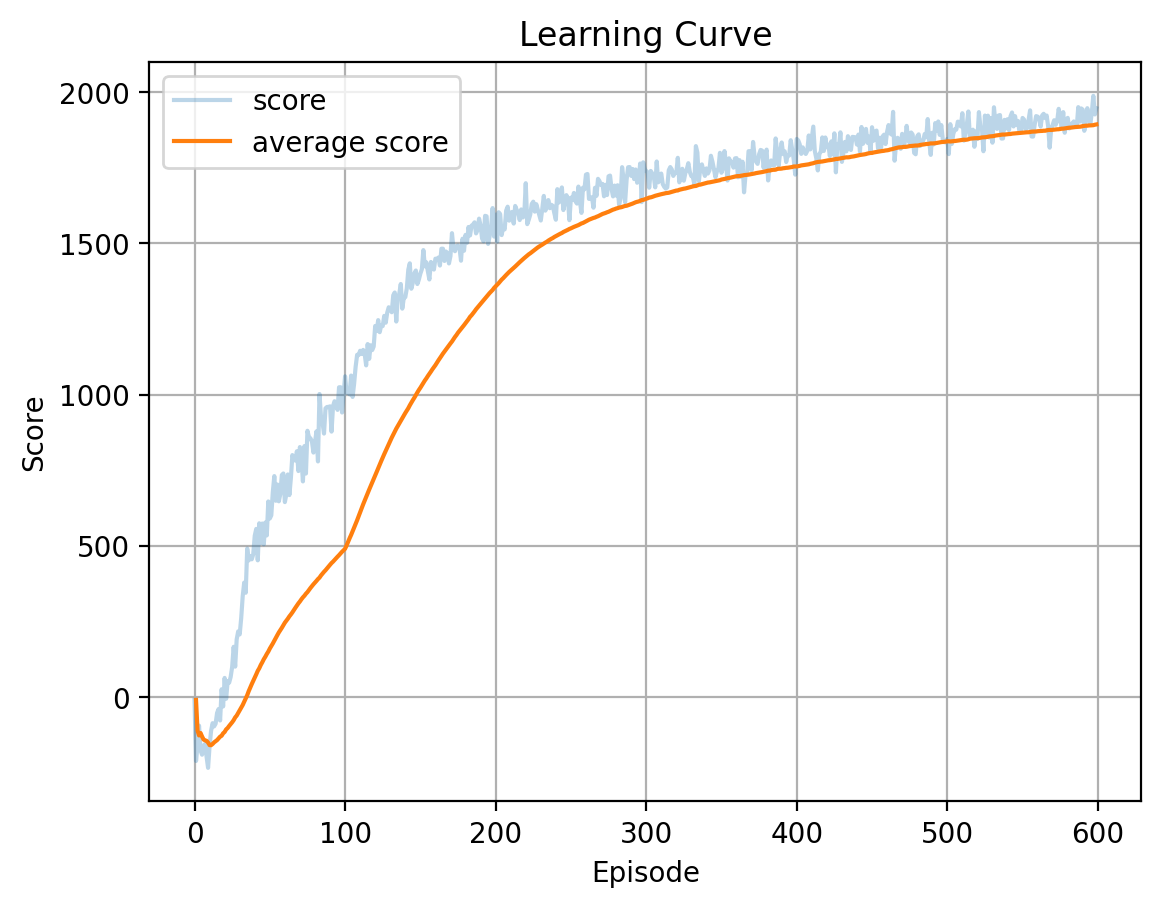

In [12]:
import gymnasium as gym
import numpy as np
from tqdm import trange
import os

# --- Environment and Agent Initialization ---
env = gym.make(env_name)
dir_path = os.path.join(dir, env_name)
os.makedirs(dir_path, exist_ok=True)

agent = Agent(gamma=gamma, alpha=alpha, beta=beta,
              state_dims=env.observation_space.shape,
              action_dims=env.action_space.shape,
              max_action=env.action_space.high,
              fc1_dim=fc1_dim, fc2_dim=fc2_dim, fc3_dim=fc3_dim,
              memory_size=memory_size,
              batch_size=batch_size, tau=tau,
              update_period=update_period,
              reward_scale=reward_scale,
              warmup=warmup,
              reparam_noise_lim=reparam_noise_lim,
              name=env_name,
              ckpt_dir=dir)

# Initialize performance tracking variables
scores = []
avg_scores = []
best_score = -1000.0

# --- Training Loop ---
for game in trange(n_games):
    # Handle the new gymnasium reset format that returns (observation, info)
    reset_result = env.reset()
    if isinstance(reset_result, tuple):
        state, info = reset_result
    else:
        state = reset_result  # Fallback for older versions

    terminated = False
    truncated = False
    score = 0

    while not (terminated or truncated):
        action = agent.choose_action(state)

        step_result = env.step(action)

        if len(step_result) == 5:
            # New gymnasium format
            next_state, reward, terminated, truncated, info = step_result
            done = terminated or truncated
        else:
            # Legacy format fallback
            next_state, reward, done, info = step_result
            terminated = done
            truncated = False

        agent.store_transition(state, action, reward, next_state, done)
        agent.learn()
        score += reward
        state = next_state

    scores.append(score)
    avg_score = np.mean(scores[-100:])
    avg_scores.append(avg_score)

    if avg_score > best_score and game != 0:
        best_score = avg_score
        agent.save_model()

    print(f'| Game: {game:6.0f} | Score: {score:10.2f} | Best score: {best_score:10.2f} | '
          f'Avg score {avg_score:10.2f} | Learning iter: {agent.learn_iter:10.0f} |')

# --- Cleanup and Plotting ---
env.close()
plot_learning_curve(scores, agent.full_path)


## 🎥 Visualize Agent Behavior

This is the last episode recorded video of the trained agent interacting with the environment in training process.

In [18]:
def just_run_agent(agent, env_name='HalfCheetah-v4', steps=1000):
    env = gym.make(env_name)  # No rendering
    state, _ = env.reset()

    score = 0
    for step in range(steps):
        action = agent.choose_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        score += reward

        if terminated or truncated:
            break

    env.close()
    print(f"Agent score: {score:.0f} in {step+1} steps")
    return score

# Test your agent:
just_run_agent(agent, env_name)


Agent score: 1887 in 1000 steps


np.float64(1887.4446631764663)

In [ ]:
import gymnasium as gym
import imageio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io

def simple_video(agent, env_name='HalfCheetah-v4', video_name='my_agent.mp4', steps=500):
    # Try different render modes
    render_modes = ['rgb_array', 'human']

    for mode in render_modes:
        print(f"Trying render mode: {mode}")
        try:
            env = gym.make(env_name, render_mode=mode)
            state, _ = env.reset()

            frames = []
            score = 0

            for step in range(min(steps, 50)):  # Start with fewer steps
                # Get frame
                if mode == 'rgb_array':
                    frame = env.render()
                else:  # human mode
                    env.render()
                    # Convert matplotlib figure to image
                    fig = plt.gcf()
                    buf = io.BytesIO()
                    fig.savefig(buf, format='png', bbox_inches='tight')
                    buf.seek(0)
                    frame = np.array(Image.open(buf))
                    plt.close(fig)

                if frame is not None and frame.size > 0:
                    frames.append(frame)
                    print(f"Frame {step}: captured ({frame.shape})")
                else:
                    print(f"Frame {step}: failed")

                # Agent step
                action = agent.choose_action(state)
                state, reward, terminated, truncated, _ = env.step(action)
                score += reward

                if terminated or truncated:
                    print(f"Episode ended at step {step}")
                    break

            env.close()

            if frames:
                print(f"Creating video with {len(frames)} frames...")
                imageio.mimsave(video_name, frames, fps=20)
                print(f"Video saved: {video_name} (Score: {score:.0f})")

                from IPython.display import Video, display
                display(Video(video_name, width=500))
                return
            else:
                print(f"No frames captured with {mode} mode")

        except Exception as e:
            print(f"Failed with {mode} mode: {e}")
            if 'env' in locals():
                env.close()

    print("All render modes failed :(")

# Run it:
simple_video(agent, env_name)
